In [85]:
import pandas as pd 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 

In [6]:
fifty_coefficients_df = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv')
coefficients_df = pd.read_csv('./pivoted_model_coefficients_for_all_features.csv')

coefficients_df_cleaned = coefficients_df.dropna() 
originalDFSet = coefficients_df['County'].unique()
cleanedDF = coefficients_df_cleaned['County'].unique()

fifty_ds_cleaned = fifty_coefficients_df.dropna()
fifty_coefficients_df = fifty_coefficients_df['County'].unique()
fifty_ds_cleaned = fifty_ds_cleaned['County'].unique()

print(set(originalDFSet) - set(cleanedDF))
print(set(fifty_coefficients_df) - set(fifty_ds_cleaned))



{'Montgomery', 'Jeff Davis', 'Bacon', 'Jenkins', 'Taliaferro', 'Ben Hill'}
{'Stewart', 'Sumter', 'Jeff Davis', 'Jasper', 'Heard', 'Jenkins', 'Webster', 'Monroe', 'Lamar', 'Cook', 'Telfair', 'Union', 'Putnam', 'Pike', 'Appling', 'Greene', 'Jones', 'Calhoun', 'Mitchell', 'Morgan', 'Baker', 'Long', 'Bulloch', 'Lee', 'Stephens', 'Upson', 'Dodge', 'Franklin', 'Quitman', 'Chattahoochee', 'Ben Hill', 'Clay', 'Glascock', 'Montgomery', 'Towns', 'Bacon', 'Dawson', 'Taliaferro', 'McIntosh', 'Atkinson', 'Chattooga', 'Laurens'}


Visual Depiction of the Features vs. Counties TradeOff: 

- A **lower NaN threshold** (e.g., 30% or less):
  - I only include features in my analysis that have a relatively low proportion of missing values. This typically means that each feature I retain is more robustly represented across counties since there's sufficient data.
  - The result is that more counties can be included because I am only considering features that these counties have enough data for.
  - However, I'll have fewer features to analyze because I've excluded those with higher amounts of missing data.

- A **higher NaN threshold** (e.g., 50% or less):
  - I've included features with a higher proportion of missing values. This allows me to retain a larger number of features for your analysis.
  - The drawback is that some counties may not have enough data to be included for these additional features, which leads to their exclusion from the analysis.
  - This can result in a dataset with more features but fewer counties.



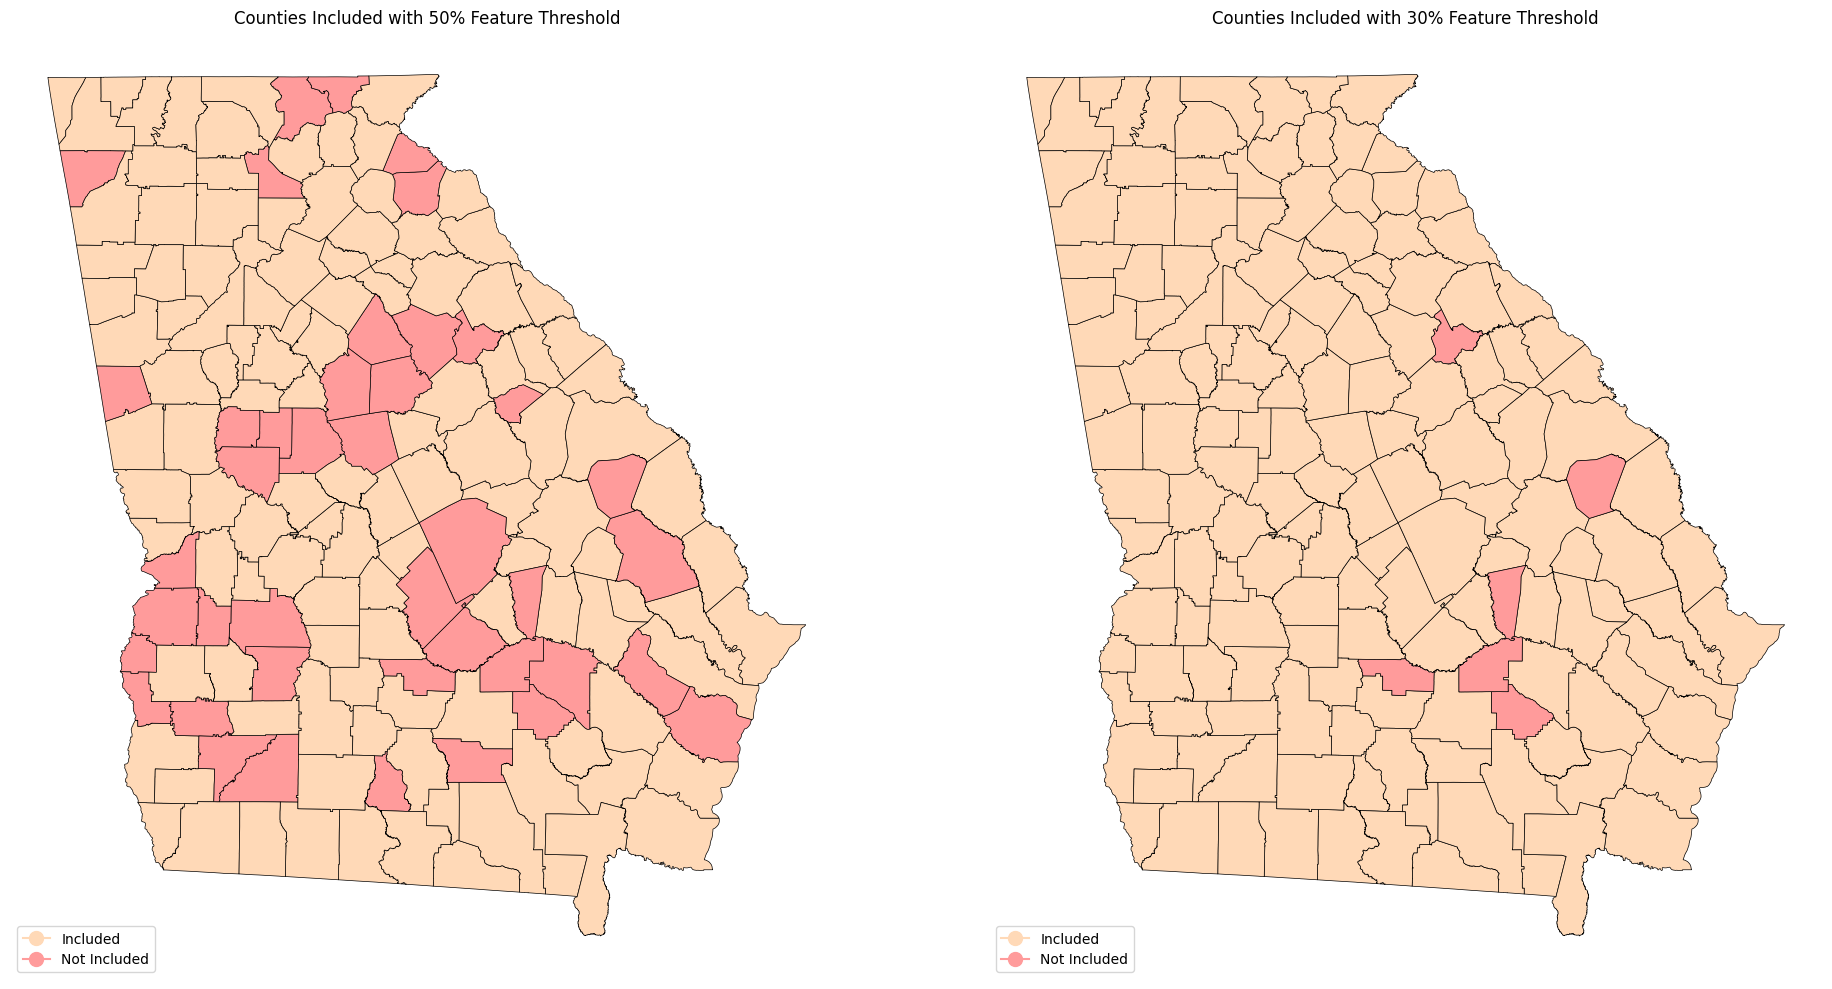

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Load datasets
cleaned_data_table = pd.read_csv("pivot_wide_format_data_cleaned.csv")
coefficients_50_threshold = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv').dropna()
coefficients_30_threshold = pd.read_csv('pivoted_model_coefficients_for_all_features.csv').dropna()

# GeoDataFrame of the Georgia counties shapefile
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Flags for whether counties are included based on the number of features meeting the threshold
geo_data['included_50_threshold'] = geo_data['NAME10'].isin(coefficients_50_threshold['County'].unique()).astype(int)
geo_data['included_30_threshold'] = geo_data['NAME10'].isin(coefficients_30_threshold['County'].unique()).astype(int)

# Define color mappings (pastel blue for included, pastel green for not included)
color_map = {0: '#FFD9B7', 1: '#FF9B9B'} 

# Manual legend elements for the custom labels without scale
legend_elements = [
    Line2D([0], [0], marker='o', color=color_map[0], label='Included', markerfacecolor=color_map[0], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[1], label='Not Included', markerfacecolor=color_map[1], markersize=10),
]

# Create maps to show included counties for each threshold
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# 50% Threshold map
geo_data.plot(column='included_50_threshold', cmap=plt.matplotlib.colors.ListedColormap([color_map[x] for x in geo_data['included_50_threshold'].unique()]),
              ax=axs[0], edgecolor='black', linewidth=0.5)  # Adjust edge color and line width as needed
axs[0].set_title('Counties Included with 50% Feature Threshold')
axs[0].axis('off')
axs[0].legend(handles=legend_elements, loc='lower left')

# 30% Threshold map
geo_data.plot(column='included_30_threshold', cmap=plt.matplotlib.colors.ListedColormap([color_map[x] for x in geo_data['included_30_threshold'].unique()]),
              ax=axs[1], edgecolor='black', linewidth=0.5)  # Adjust edge color and line width as needed
axs[1].set_title('Counties Included with 30% Feature Threshold')
axs[1].axis('off')
axs[1].legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()


First Step: Visualizations and Principal Component Analysis 

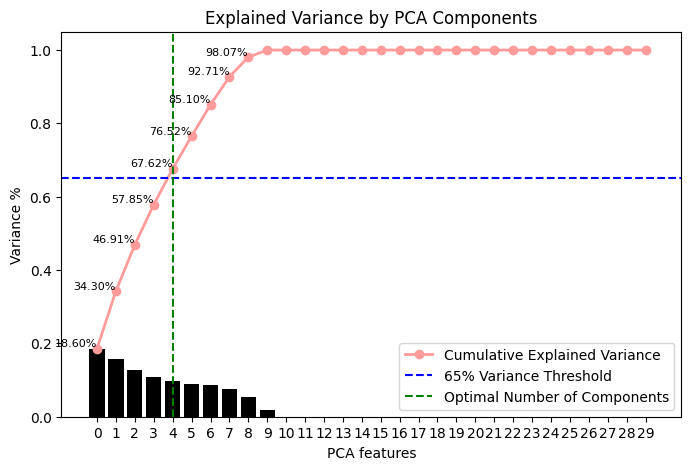

Number of components to explain 65.0% variance: 5


In [306]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values
variance_threshold = 0.65  # Setting the threshold to 65%

# Fit PCA and plot the individual explained variance
pca = PCA()
pca.fit(X)

features = range(pca.n_components_)
plt.figure(figsize=(8, 5))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title('Explained Variance by PCA Components')

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance trend line
plt.plot(features, cumulative_variance, color='#FF9B9B', marker='o', linestyle='-', linewidth=2, label='Cumulative Explained Variance')

# Annotate the points for the first 9 features or until cumulative variance reaches 100%
for i, v in enumerate(cumulative_variance):
    if v < 1.0 and i < 9:  # Check if the cumulative variance is less than 100% and within the first 9 features
        plt.text(i, v, f"{v:.2%}", fontsize=8, ha='right', va='bottom')

# Add a horizontal line at the 65% variance threshold
plt.axhline(y=variance_threshold, color='blue', linestyle='--', label='65% Variance Threshold')

# Find the number of components for the desired threshold and add a vertical line at this point
components_for_threshold = np.argmax(cumulative_variance >= variance_threshold) + 1
plt.axvline(x=components_for_threshold-1, color='green', linestyle='--', label='Optimal Number of Components')

# Show the plot with legends
plt.legend()
plt.show()

# Print the number of components required to explain the desired threshold of variance
print(f"Number of components to explain {variance_threshold*100}% variance: {components_for_threshold}")


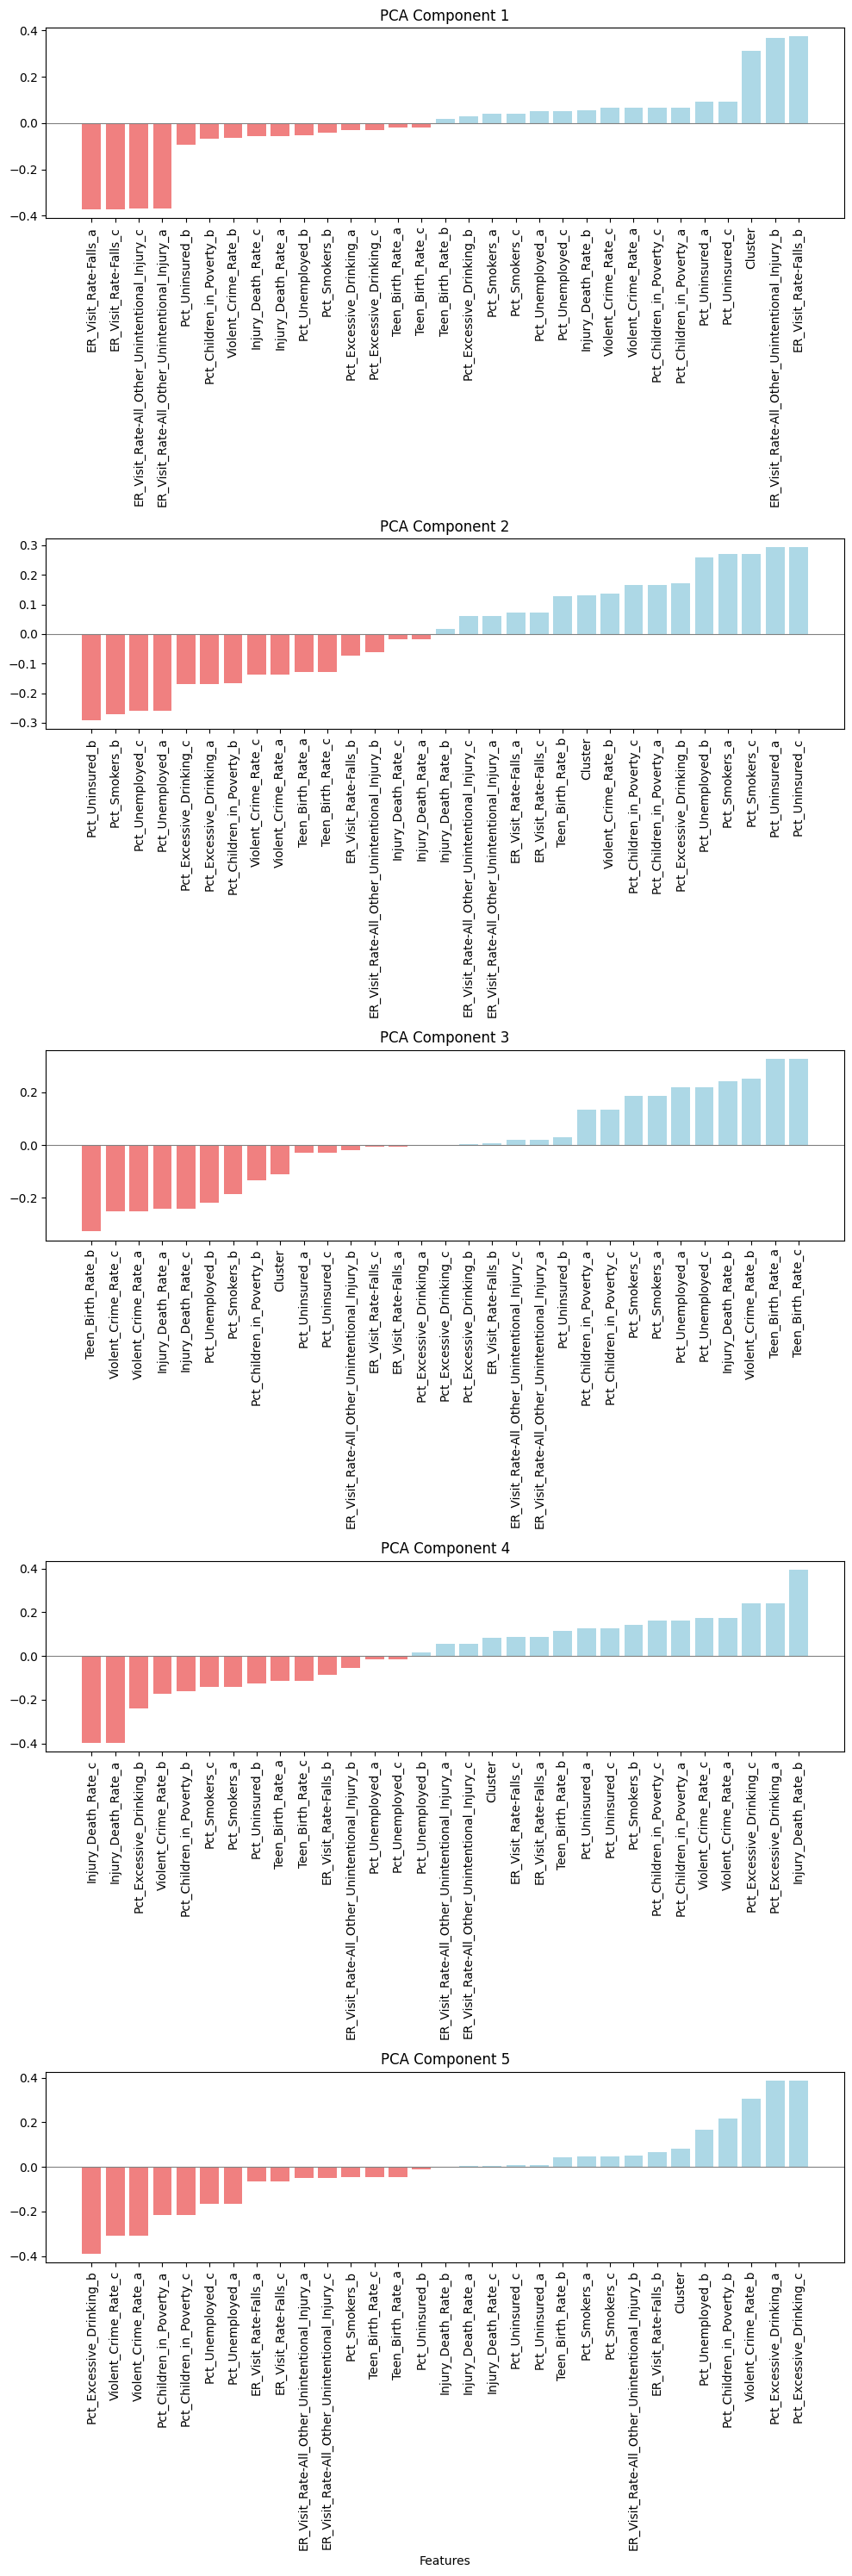

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'coefficients_df_cleaned' contains the data and 'County' is a column to exclude
features = coefficients_df_cleaned.columns.drop('County')
X = coefficients_df_cleaned[features].values

# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Get loadings
loadings = pca.components_

# Create a figure with subplots for each PCA component
fig, axs = plt.subplots(5, 1, figsize=(10, 30))  # Adjust the size as needed

# Plot each PCA component's loadings, sorted by value
for i in range(5):
    # Get loading values and sort them along with feature names
    loading_values = loadings[i, :]
    indices = np.argsort(loading_values)  # Get sorted order
    sorted_loadings = loading_values[indices]  # Apply sorted order
    sorted_features = features[indices]  # Apply sorted order to feature names
    
    # Determine colors based on sorted loading values
    bar_colors = ['lightcoral' if x < 0 else 'lightblue' for x in sorted_loadings]
    
    # Plot bars with sorted values
    bars = axs[i].bar(sorted_features, sorted_loadings, color=bar_colors)
    axs[i].set_title(f'PCA Component {i+1}')
    axs[i].set_xticks(range(len(sorted_features)))
    axs[i].set_xticklabels(sorted_features, rotation=90)  # Rotate the feature names for better visibility
    axs[i].axhline(0, color='grey', linewidth=0.8)

# Set the xlabel for the last subplot
axs[-1].set_xlabel('Features')

plt.tight_layout()
plt.show()


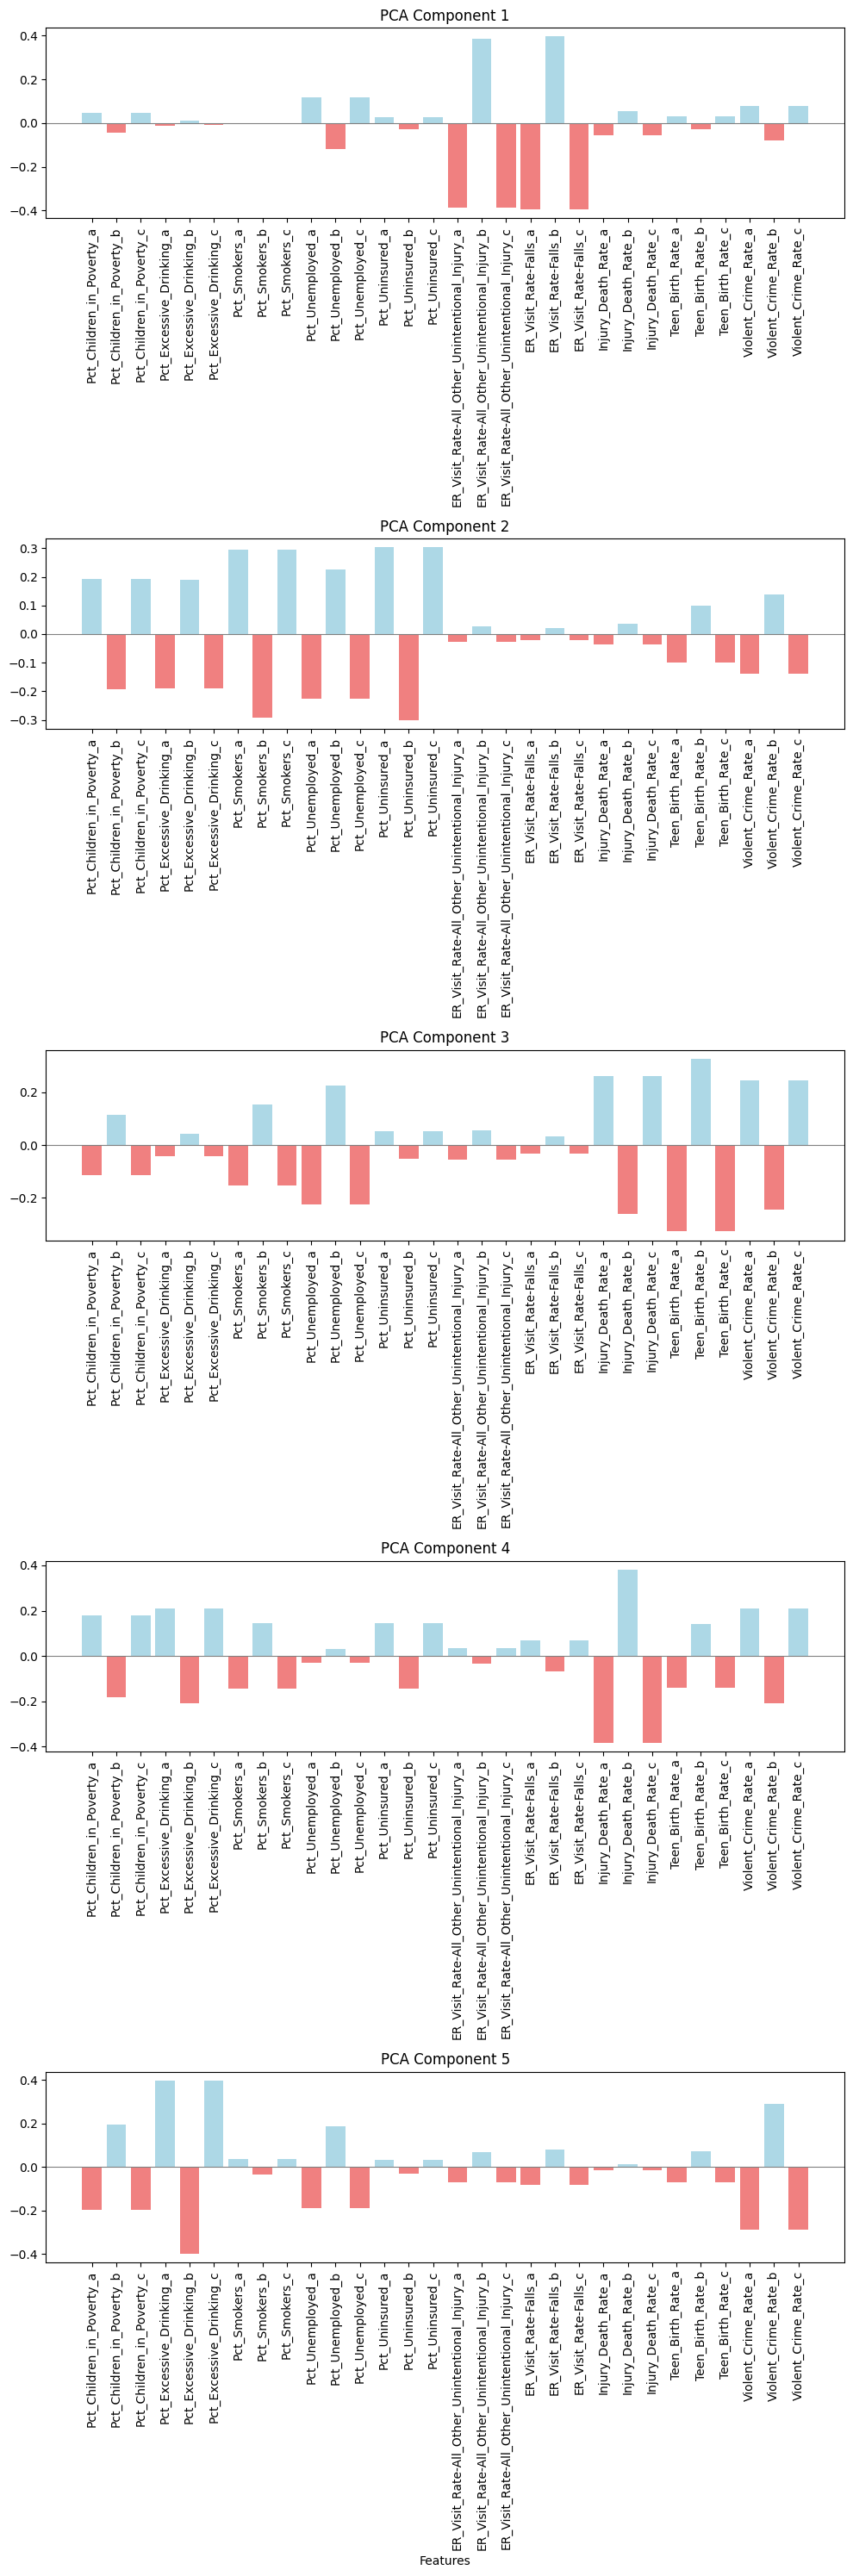

In [312]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X' is your dataset and 'features' contains your feature names
features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values

# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Get loadings
loadings = pca.components_

# Create a figure with subplots for each PCA component
fig, axs = plt.subplots(5, 1, figsize=(10, 30))  # Adjust the size as needed

# Plot each PCA component's loadings
for i in range(5):
    loading_values = loadings[i, :]
    bar_colors = ['lightblue' if x > 0 else 'lightcoral' for x in loading_values]
    bars = axs[i].bar(features, loading_values, color=bar_colors)
    axs[i].set_title(f'PCA Component {i+1}')
    axs[i].set_xticks(range(len(features)))
    axs[i].set_xticklabels(features, rotation=90)  # Rotate the feature names for better visibility
    axs[i].axhline(0, color='grey', linewidth=0.8)

# Set the xlabel for the last subplot
axs[-1].set_xlabel('Features')

plt.tight_layout()
plt.show()


In [317]:
import pandas as pd
from sklearn.decomposition import PCA

# Let's say 'X' is your dataset and 'features' is the list of column names
pca = PCA(n_components=5)
pca.fit(X)

# Create a DataFrame with the loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PCA Component #{i+1}' for i in range(5)], index=features)

# Function to map each feature to its most contributing PCA component
def map_features_to_components(loadings_df):
    feature_component_map = {}
    for feature in loadings_df.index:
        dominant_component = loadings_df.loc[feature].abs().idxmax()
        if dominant_component in feature_component_map:
            feature_component_map[dominant_component].append(feature)
        else:
            feature_component_map[dominant_component] = [feature]
    return feature_component_map

# Map the features to components
features_mapped_to_components = map_features_to_components(loadings)

# Print the mapping
for component, features_list in features_mapped_to_components.items():
    print(f"{component} key features: {', '.join(features_list)}")


PCA Component #5 key features: Pct_Children_in_Poverty_a, Pct_Children_in_Poverty_b, Pct_Children_in_Poverty_c, Pct_Excessive_Drinking_a, Pct_Excessive_Drinking_b, Pct_Excessive_Drinking_c, Violent_Crime_Rate_a, Violent_Crime_Rate_b, Violent_Crime_Rate_c
PCA Component #2 key features: Pct_Smokers_a, Pct_Smokers_b, Pct_Smokers_c, Pct_Uninsured_a, Pct_Uninsured_b, Pct_Uninsured_c
PCA Component #3 key features: Pct_Unemployed_a, Pct_Unemployed_b, Pct_Unemployed_c, Teen_Birth_Rate_a, Teen_Birth_Rate_b, Teen_Birth_Rate_c
PCA Component #1 key features: ER_Visit_Rate-All_Other_Unintentional_Injury_a, ER_Visit_Rate-All_Other_Unintentional_Injury_b, ER_Visit_Rate-All_Other_Unintentional_Injury_c, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_b, ER_Visit_Rate-Falls_c
PCA Component #4 key features: Injury_Death_Rate_a, Injury_Death_Rate_b, Injury_Death_Rate_c


/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_4237/3689592610.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], palette="viridis", legend='full')


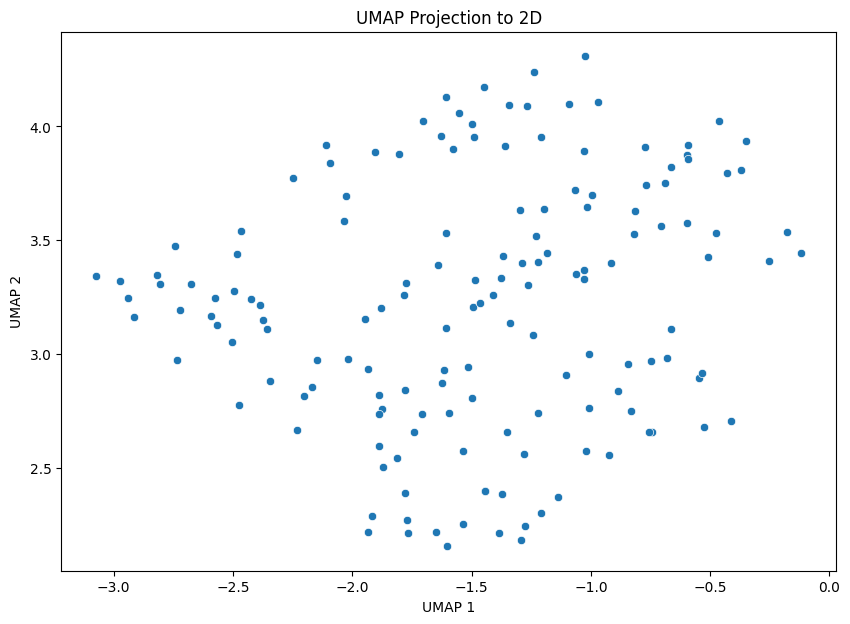

/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_4237/3689592610.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap='viridis', edgecolor='k')


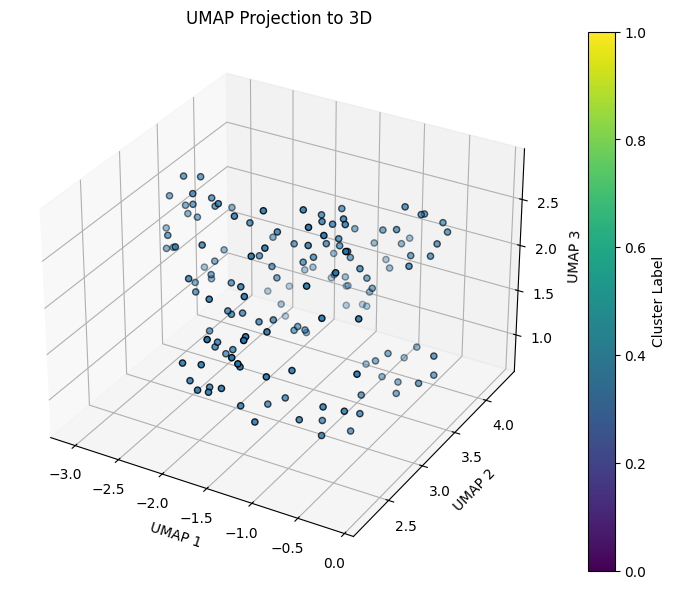

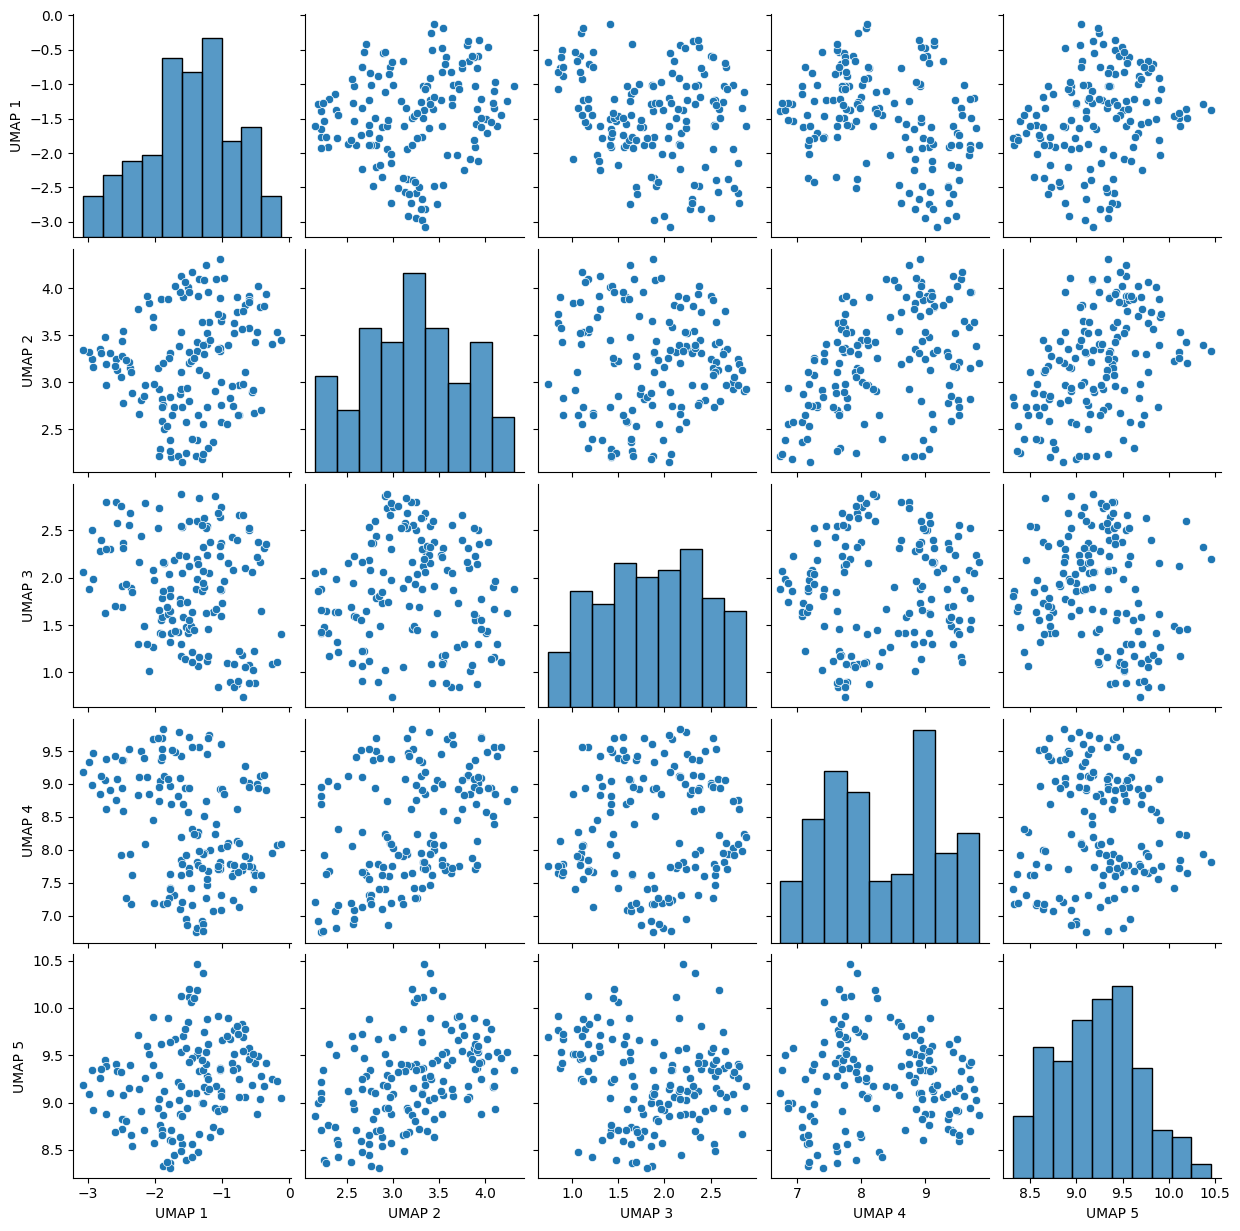

In [10]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

features_to_scale = coefficients_df_cleaned.columns.drop('County')

# Assuming 'X' is your dataset
X = coefficients_df_cleaned[features_to_scale].values

# Reduce the dimension to 5 using UMAP
reducer = umap.UMAP(n_components=5, random_state=42)
X_umap = reducer.fit_transform(X)

# For visualization, we can only plot in 2D or 3D directly.
# Let's plot the first 2 components as an example.
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], palette="viridis", legend='full')
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# And a 3D plot for the first three components
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap='viridis', edgecolor='k')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('UMAP Projection to 3D')
plt.show()


# Create a DataFrame from the UMAP output for easier plotting
umap_df = pd.DataFrame(X_umap, columns=[f'UMAP {i+1}' for i in range(5)])

# Use seaborn's pairplot to visualize the distribution and relationship of components
sns.pairplot(umap_df)
plt.show()


Second Step: Clustering 

Determined the optimal number of clusters using nbclust package: R, elbow method, sillhouette scores graph 

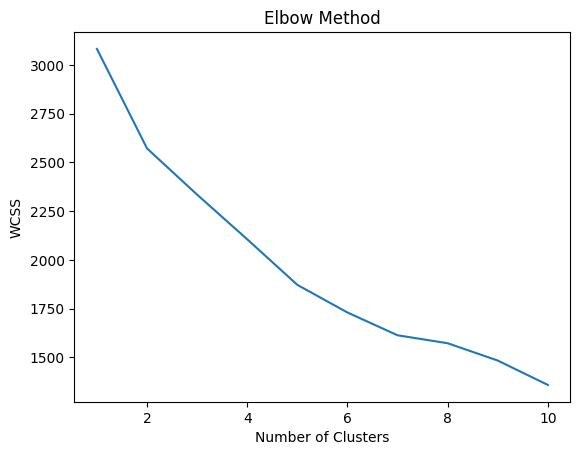

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

coefficients_df_cleaned = coefficients_df.dropna() 

features_to_scale = coefficients_df_cleaned.columns.drop('County')
#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title("Elbow Method")
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS")
plt.show() 

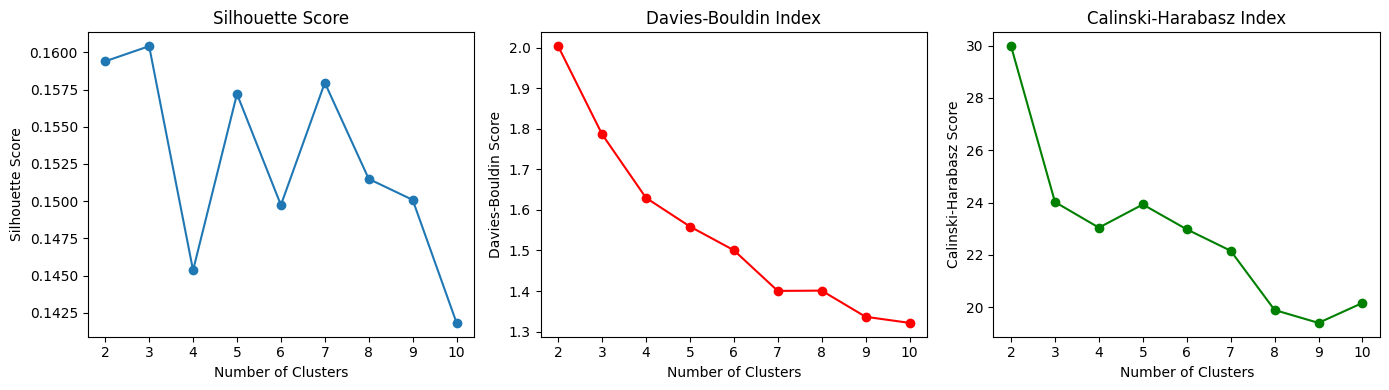

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
X = X_pca

# Prepare lists to store the scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Range of cluster numbers to try
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Compute the metrics
    silhouette_avg = silhouette_score(X, cluster_labels)
    davies_bouldin = davies_bouldin_score(X, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

    # Store the scores
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

# Plot the Silhouette Score
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel('Number of Clusters')
plt.ylabel("Silhouette Score")

# Plot the Davies-Bouldin Index (remember, for this metric, lower is better)
plt.subplot(132)
plt.plot(n_clusters_range, davies_bouldin_scores, marker='o', color='r')
plt.title("Davies-Bouldin Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Davies-Bouldin Score")

# Plot the Calinski-Harabasz Index
plt.subplot(133)
plt.plot(n_clusters_range, calinski_harabasz_scores, marker='o', color='g')
plt.title("Calinski-Harabasz Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Calinski-Harabasz Score")

plt.tight_layout()
plt.show()


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_4237/2077050830.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels


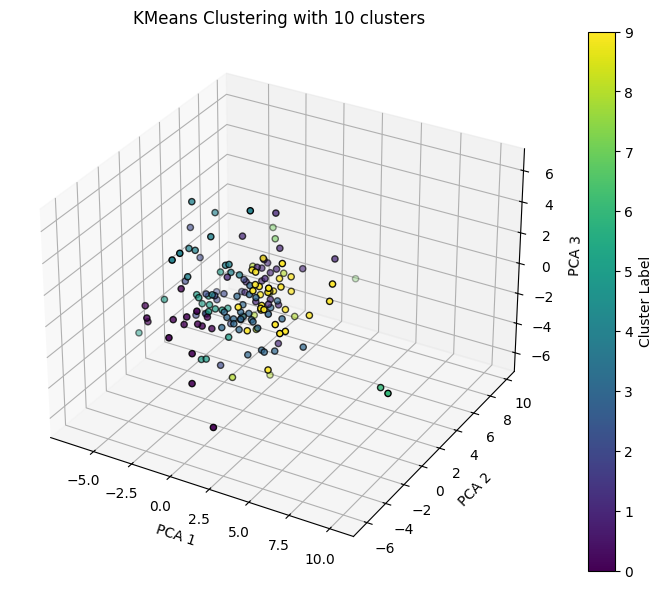

     cluster
0          4
1          6
2          8
3          0
4          1
..       ...
148        3
149        1
150        3
151        1
152        5

[153 rows x 1 columns]
cluster
0    16
1    21
2    14
3    28
4    14
5    16
6     2
7     3
8     9
9    30
dtype: int64


In [36]:
from sklearn.cluster import KMeans


coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

n_clusters = 10

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels


from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 10 clusters')

plt.show()

# Create a new dataframe with the cluster labels
df_clusters = pd.DataFrame({'cluster': cluster_labels})

# Print the new dataframe
print(df_clusters)

print(df_clusters.groupby('cluster').size())


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_4237/25027634.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels


Silhouette Score: 0.1604149487993108
Davies-Bouldin Index: 1.7863558717882189
Calinski-Harabasz Index: 24.018849593656327


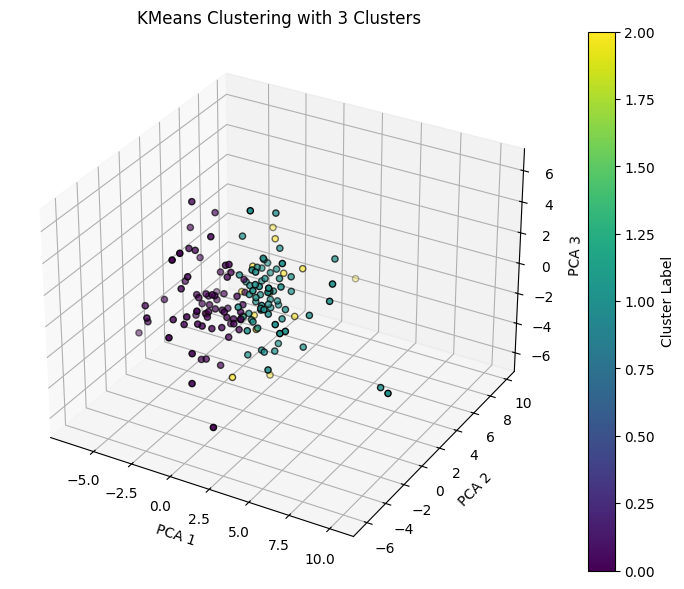

     cluster
0          0
1          1
2          2
3          0
4          1
..       ...
148        1
149        1
150        1
151        0
152        0

[153 rows x 1 columns]
cluster
0    69
1    69
2    15
dtype: int64


In [52]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

# Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

n_clusters = 3

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels

# Calculate clustering performance metrics
silhouette = silhouette_score(X_pca, cluster_labels)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)

# Print the scores
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 3 Clusters')

plt.show()

# Create a new dataframe with the cluster labels
df_clusters = pd.DataFrame({'cluster': cluster_labels})

# Print the new dataframe
print(df_clusters)

# Print cluster counts
print(df_clusters.groupby('cluster').size())


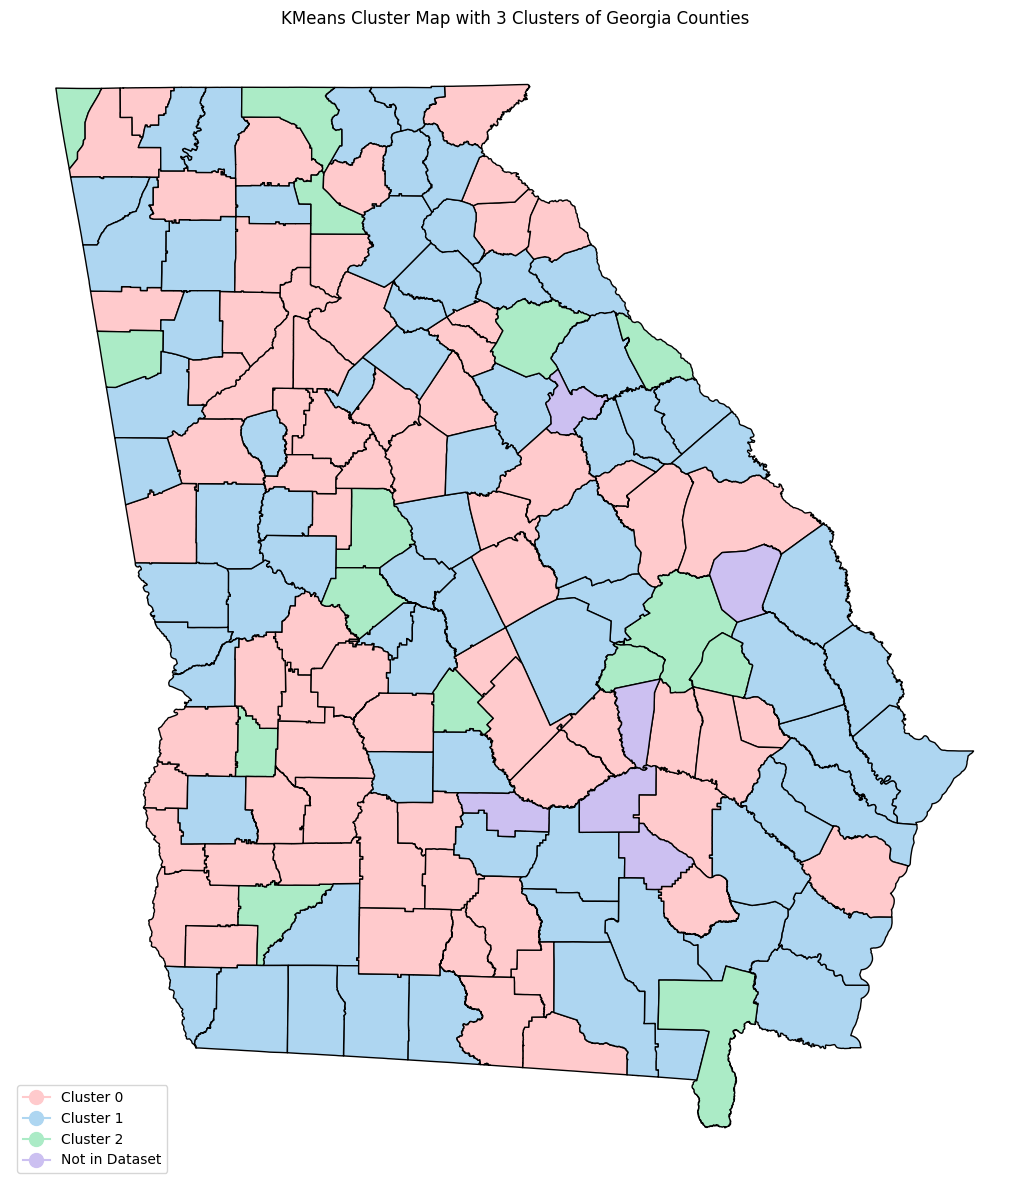

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming 'geo_data' is your GeoDataFrame of Georgia counties
# Load the GeoDataFrame of Georgia counties if not already loaded
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Ensure 'coefficients_df_cleaned' has the 'Cluster' column from KMeans
# If not, add it
# coefficients_df_cleaned['Cluster'] = cluster_labels  # Uncomment if not already done

# Merge the geographical data with the KMeans cluster data
geo_data_merged = geo_data.merge(coefficients_df_cleaned[['County', 'Cluster']], how='left', left_on='NAME10', right_on='County')

# Define color mappings for each cluster
# Adjust colors as desired
color_map = {
    0: '#FFCACC',  # Color for cluster 0
    1: '#AED6F1',  # Color for cluster 1
    2: '#ABEBC6',  # Color for cluster 2
}

# Assign colors to counties based on the cluster they belong to
geo_data_merged['color'] = geo_data_merged['Cluster'].apply(lambda x: color_map.get(x, '#CCC0F1'))  # Use a neutral color for counties not in the dataset

# Create manual legend elements for the custom labels
legend_elements = [
    Line2D([0], [0], marker='o', color=color_map[0], label='Cluster 0', markerfacecolor=color_map[0], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[1], label='Cluster 1', markerfacecolor=color_map[1], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[2], label='Cluster 2', markerfacecolor=color_map[2], markersize=10),
    Line2D([0], [0], marker='o', color='#CCC0F1', label='Not in Dataset', markerfacecolor='#CCC0F1', markersize=10),
]

# Plotting the map with clusters
fig, ax = plt.subplots(1, figsize=(12, 12))
geo_data_merged.plot(color=geo_data_merged['color'], ax=ax, edgecolor='black', linewidth=1)

# Set title and axes properties
ax.set_title('KMeans Cluster Map with 3 Clusters of Georgia Counties')
ax.axis('off')

# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_4237/1778753651.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels


Silhouette Score: 0.15939860524442168
Davies-Bouldin Index: 2.0033209150564746
Calinski-Harabasz Index: 29.983121395397486


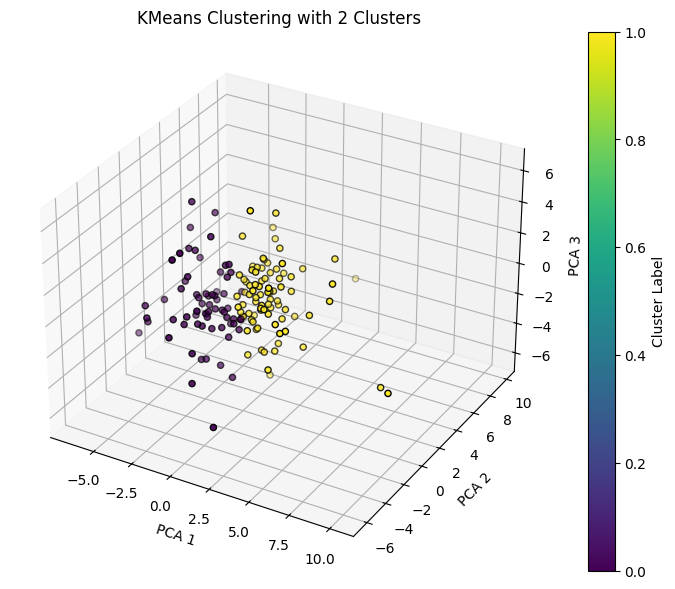

In [51]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

# Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

n_clusters = 2

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels

# Calculate clustering performance metrics
silhouette = silhouette_score(X_pca, cluster_labels)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)

# Print the scores
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('KMeans Clustering with 2 Clusters')

plt.show()


In [84]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Assuming X_pca is your PCA-reduced dataset
X = X_pca

# Define ranges for eps with step size of 0.5
eps_values = np.arange(1, 10, 0.1)
min_samples_values = range(2, 25)  # 2 * numDimensions

# Initialize dictionaries to track the best scores and corresponding parameters
best_silhouette = {'score': -1, 'eps': None, 'min_samples': None}
best_davies_bouldin = {'score': np.inf, 'eps': None, 'min_samples': None}
best_calinski_harabasz = {'score': -1, 'eps': None, 'min_samples': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X)

        # Skip if only one cluster is found or all points are considered noise
        if len(np.unique(clusters)) < 2 or (clusters == -1).all():
            continue

        # Calculate metrics
        silhouette = silhouette_score(X, clusters)
        davies_bouldin = davies_bouldin_score(X, clusters)
        calinski_harabasz = calinski_harabasz_score(X, clusters)

        # Update best silhouette score
        if silhouette > best_silhouette['score']:
            best_silhouette['score'] = silhouette
            best_silhouette['eps'] = eps
            best_silhouette['min_samples'] = min_samples

        # Update best Davies-Bouldin score (lower is better)
        if davies_bouldin < best_davies_bouldin['score']:
            best_davies_bouldin['score'] = davies_bouldin
            best_davies_bouldin['eps'] = eps
            best_davies_bouldin['min_samples'] = min_samples

        # Update best Calinski-Harabasz score
        if calinski_harabasz > best_calinski_harabasz['score']:
            best_calinski_harabasz['score'] = calinski_harabasz
            best_calinski_harabasz['eps'] = eps
            best_calinski_harabasz['min_samples'] = min_samples

# Print the best parameters and scores for each metric
print("Silhouette Score:")
print(f"Best Score: {best_silhouette['score']}, eps: {best_silhouette['eps']}, min_samples: {best_silhouette['min_samples']}")
print("Davies-Bouldin Index:")
print(f"Best Score: {best_davies_bouldin['score']}, eps: {best_davies_bouldin['eps']}, min_samples: {best_davies_bouldin['min_samples']}")
print("Calinski-Harabasz Index:")
print(f"Best Score: {best_calinski_harabasz['score']}, eps: {best_calinski_harabasz['eps']}, min_samples: {best_calinski_harabasz['min_samples']}")

Silhouette Score:
Best Score: 0.47734672685887813, eps: 6.200000000000005, min_samples: 4
Davies-Bouldin Index:
Best Score: 0.37738960295456725, eps: 6.200000000000005, min_samples: 2
Calinski-Harabasz Index:
Best Score: 7.100852549290081, eps: 5.100000000000003, min_samples: 7


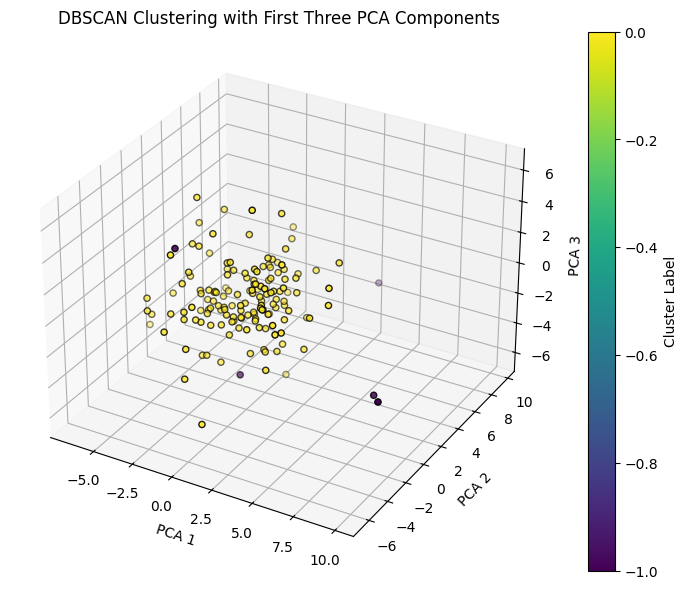

[ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN



# Assuming 'X' is your dataset
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Run DBSCAN
dbscan = DBSCAN(eps=5.1, min_samples=7)
clusters = dbscan.fit_predict(X_pca)

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('DBSCAN Clustering with First Three PCA Components')

plt.show()

print(clusters)

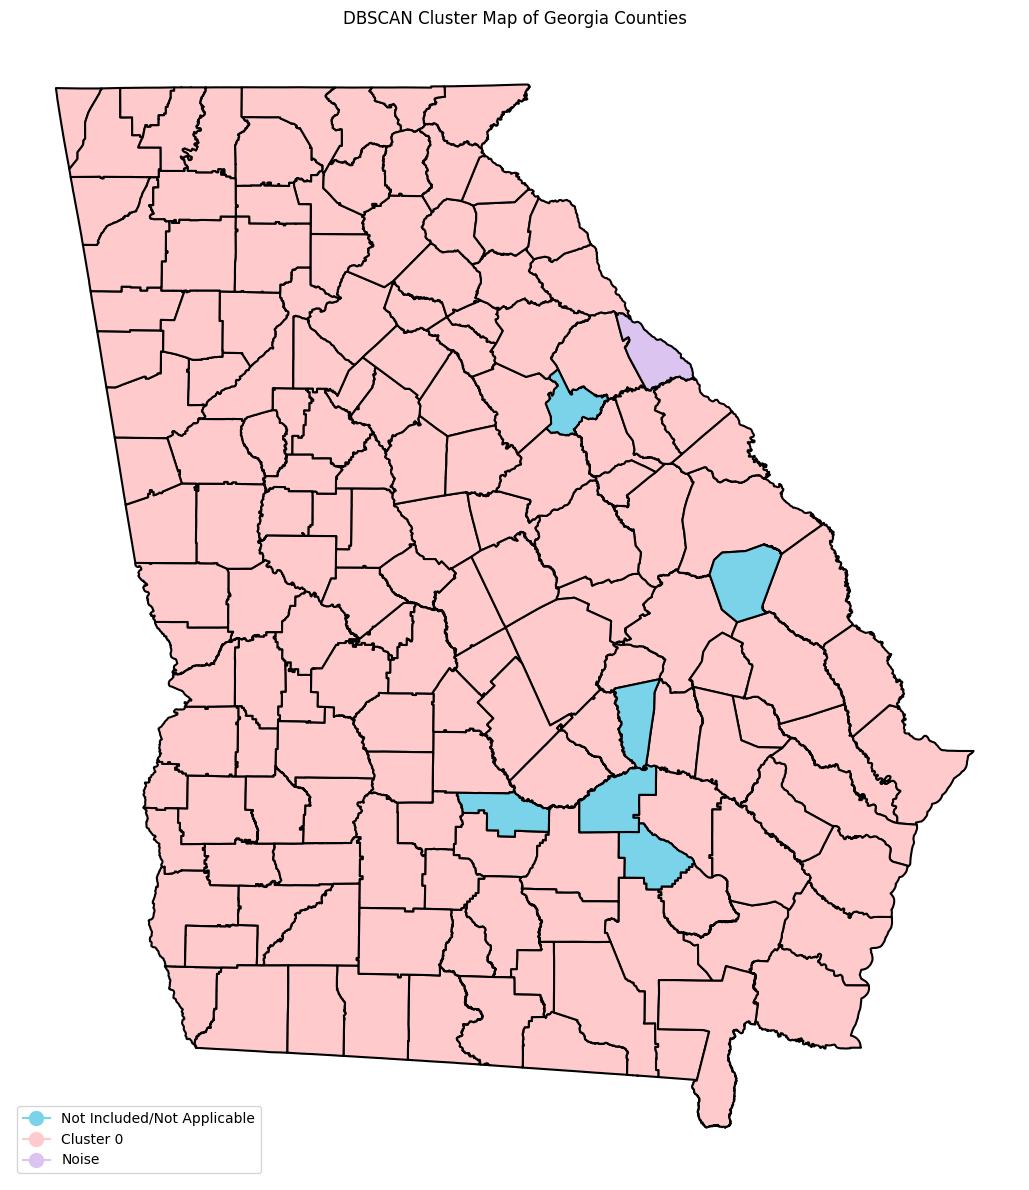

In [86]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Load the GeoDataFrame of Georgia counties
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Create a DataFrame from the clusters
cluster_df = pd.DataFrame({'County': coefficients_df_cleaned['County'], 'Cluster': clusters})

# Merge the geographical data with the cluster data
geo_data = geo_data.merge(cluster_df, how='left', left_on='NAME10', right_on='County')

# Define color mappings for cluster and noise
color_map = {0: '#FFCACC', -1: '#DBC4F0'}  # pink for cluster 0, purple for noise

# Assign colors to counties based on the cluster they belong to
geo_data['color'] = geo_data['Cluster'].apply(lambda x: color_map.get(x, '#7BD3EA'))  # default light blue for counties not in the dataset

# Create manual legend elements for the custom labels
legend_elements = [
    Line2D([0], [0], marker='o', color='#7BD3EA', label='Not Included/Not Applicable', markerfacecolor='#7BD3EA', markersize=10),
    Line2D([0], [0], marker='o', color=color_map[0], label='Cluster 0', markerfacecolor=color_map[0], markersize=10),
    Line2D([0], [0], marker='o', color=color_map[-1], label='Noise', markerfacecolor=color_map[-1], markersize=10),
]

# Plotting the map with clusters, including thicker borders for the counties
fig, ax = plt.subplots(1, figsize=(12, 12))
geo_data.plot(color=geo_data['color'], ax=ax, edgecolor='black', linewidth=1.5)  # Adjust edge color and line width as needed

# Set title and axes properties
ax.set_title('DBSCAN Cluster Map of Georgia Counties')
ax.axis('off')

# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()

Hierarchical (Agglomerative) Clustering 

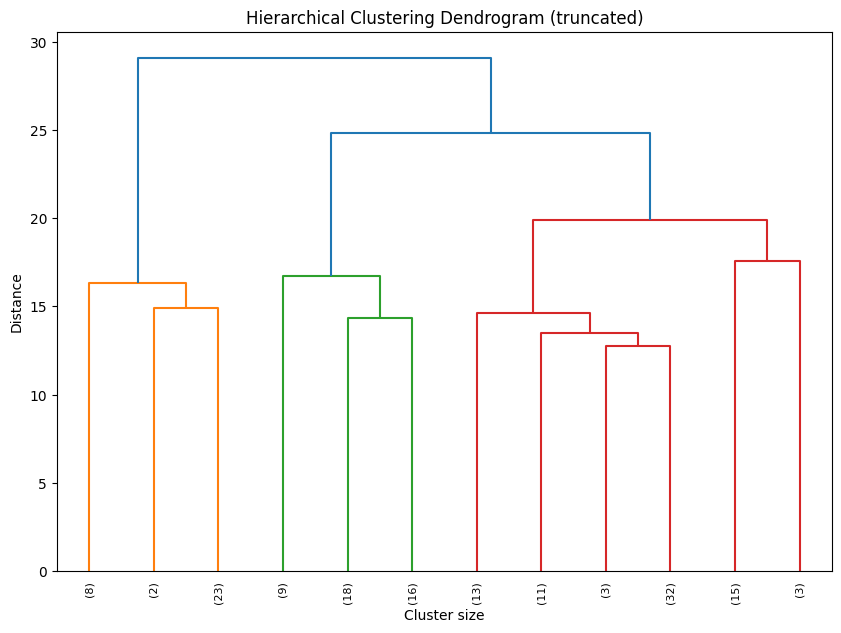

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Assuming 'X' is your dataset
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Perform hierarchical clustering
Z = linkage(X_pca, 'ward')  # 'ward' is one method of calculating distance between clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    Z,
    truncate_mode='lastp',  # This option allows you to truncate the dendrogram to show the last p merged clusters
    p=12,  # showing the last 12 merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')

plt.show()


In [77]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

coefficients_df_cleaned = coefficients_df.dropna()
features_to_scale = coefficients_df_cleaned.columns.drop('County')

# Assuming 'X' is your dataset
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
X = X_pca

# Define the parameter range for n_clusters
n_clusters_range = range(2, 10)  # Example: from 2 to 9 clusters

# Initialize dictionaries to track the best scores and corresponding parameters
best_silhouette = {'score': -1, 'n_clusters': None, 'linkage': None}
best_davies_bouldin = {'score': np.inf, 'n_clusters': None, 'linkage': None}
best_calinski_harabasz = {'score': -1, 'n_clusters': None, 'linkage': None}

# Define linkage methods to iterate over
linkage_methods = ['ward', 'complete', 'average', 'single']

# Perform grid search
for n_clusters in n_clusters_range:
    for linkage in linkage_methods:
        # Create and fit the model
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        cluster_labels = model.fit_predict(X)
        
        # Calculate metrics
        silhouette = silhouette_score(X, cluster_labels)
        davies_bouldin = davies_bouldin_score(X, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(X, cluster_labels)
        
        # Update best silhouette score
        if silhouette > best_silhouette['score']:
            best_silhouette['score'] = silhouette
            best_silhouette['n_clusters'] = n_clusters
            best_silhouette['linkage'] = linkage
        
        # Update best Davies-Bouldin score (lower is better)
        if davies_bouldin < best_davies_bouldin['score']:
            best_davies_bouldin['score'] = davies_bouldin
            best_davies_bouldin['n_clusters'] = n_clusters
            best_davies_bouldin['linkage'] = linkage
        
        # Update best Calinski-Harabasz score
        if calinski_harabasz > best_calinski_harabasz['score']:
            best_calinski_harabasz['score'] = calinski_harabasz
            best_calinski_harabasz['n_clusters'] = n_clusters
            best_calinski_harabasz['linkage'] = linkage

# Print the best parameters and scores for each metric
print("Silhouette Score:")
print(f"Best Score: {best_silhouette['score']}, n_clusters: {best_silhouette['n_clusters']}, linkage: {best_silhouette['linkage']}")
print("Davies-Bouldin Index:")
print(f"Best Score: {best_davies_bouldin['score']}, n_clusters: {best_davies_bouldin['n_clusters']}, linkage: {best_davies_bouldin['linkage']}")
print("Calinski-Harabasz Index:")
print(f"Best Score: {best_calinski_harabasz['score']}, n_clusters: {best_calinski_harabasz['n_clusters']}, linkage: {best_calinski_harabasz['linkage']}")


Silhouette Score:
Best Score: 0.47302327933798877, n_clusters: 2, linkage: average
Davies-Bouldin Index:
Best Score: 0.37773995887623935, n_clusters: 2, linkage: average
Calinski-Harabasz Index:
Best Score: 24.088593610450747, n_clusters: 2, linkage: ward


[0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 0 0]


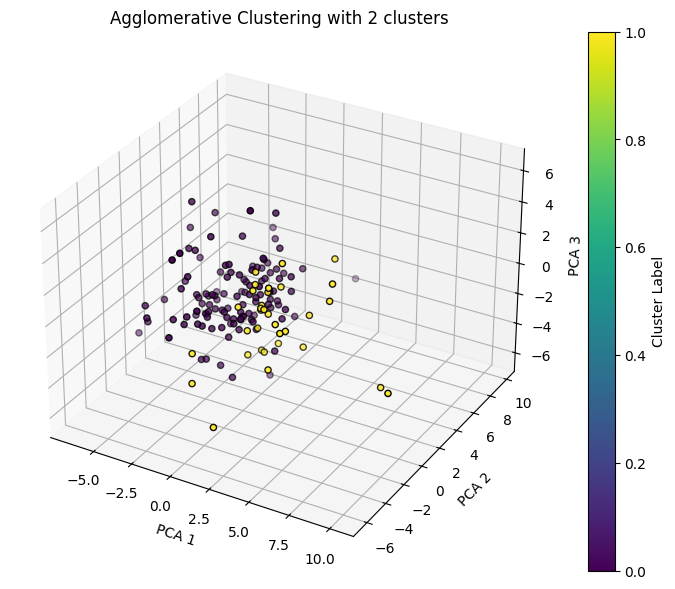

In [49]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Assuming X_pca is your PCA-reduced dataset
# Assuming 'X' is your dataset ready for PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Step 2: Choose the linkage criterion
linkage = 'ward'  # Other options: 'complete', 'average', 'single'

# Step 3: Fit the hierarchical clustering
agg_clustering = AgglomerativeClustering(linkage=linkage, n_clusters=2, compute_full_tree=True)
agg_clustering.fit(X_pca)

# Step 4: Extract cluster labels
cluster_labels_agg = agg_clustering.labels_
print(cluster_labels_agg)

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels_agg, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('Agglomerative Clustering with 2 clusters')

plt.show()


[0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 0 0]
Silhouette Score: 0.1700813810295997
Davies-Bouldin Index: 1.8599640727003632
Calinski-Harabasz Index: 24.088593610450747


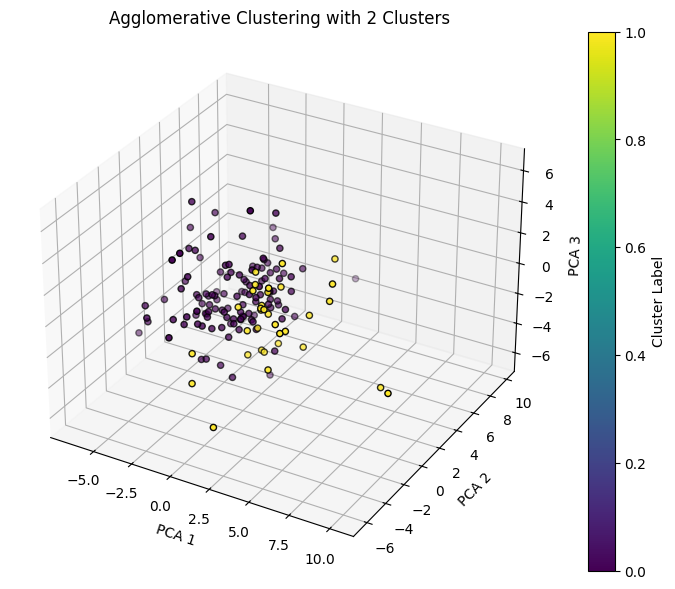

In [55]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_pca is your PCA-reduced dataset

# Step 2: Choose the linkage criterion
linkage = 'ward'  # Other options: 'complete', 'average', 'single'

# Step 3: Fit the hierarchical clustering
agg_clustering = AgglomerativeClustering(linkage=linkage, n_clusters=2, compute_full_tree=True)
agg_clustering.fit(X_pca)

# Step 4: Extract cluster labels
cluster_labels_agg = agg_clustering.labels_
print(cluster_labels_agg)

# Calculate clustering performance metrics
silhouette = silhouette_score(X_pca, cluster_labels_agg)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels_agg)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels_agg)

# Print the scores
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels_agg, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('Agglomerative Clustering with 2 Clusters')

plt.show()


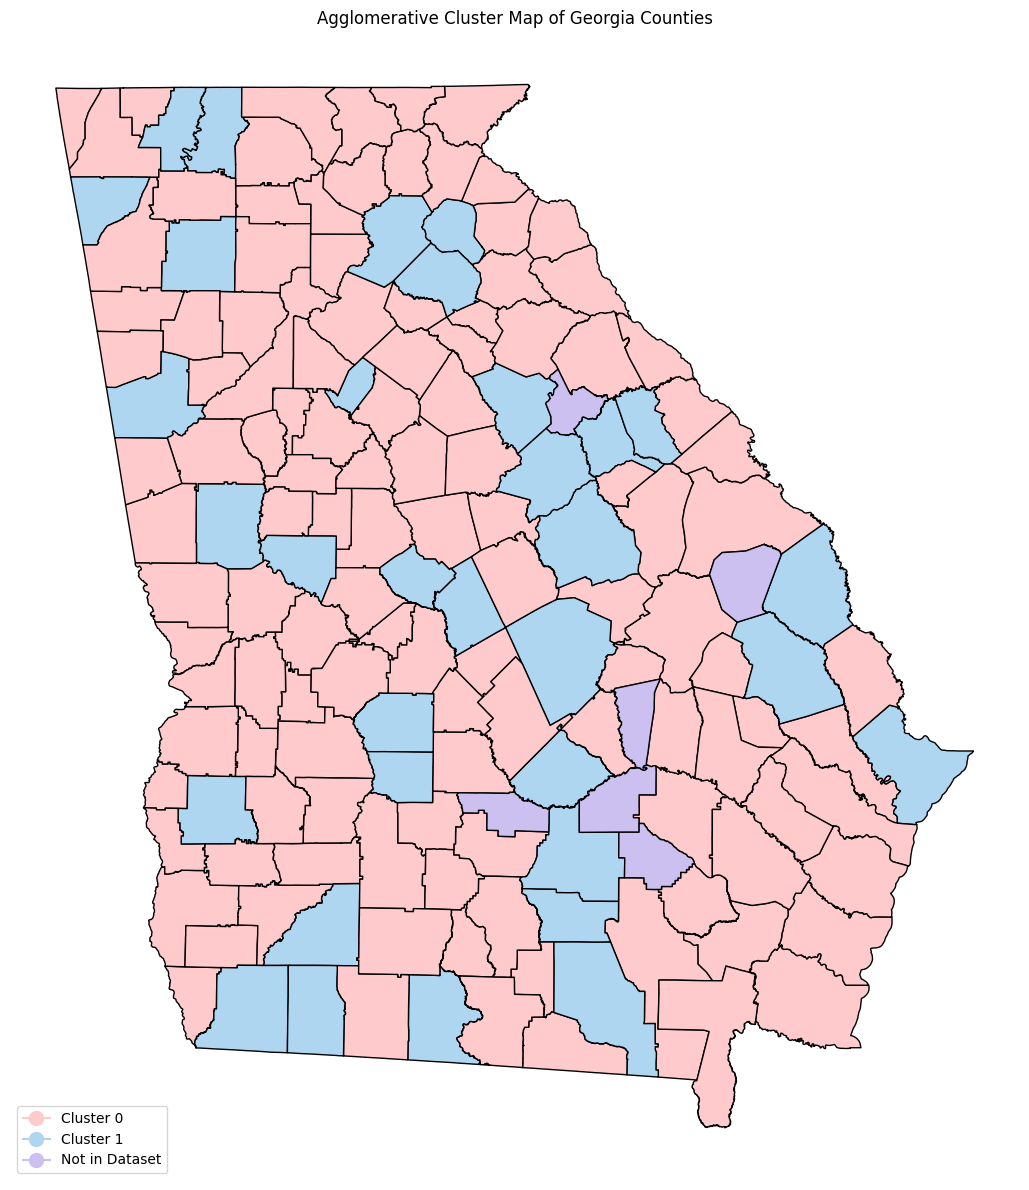

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming 'geo_data' is your GeoDataFrame of Georgia counties
# Load the GeoDataFrame of Georgia counties if not already loaded
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Create a DataFrame with the cluster labels from Agglomerative Clustering
agg_cluster_df = pd.DataFrame({'County': coefficients_df_cleaned['County'], 'Cluster': cluster_labels_agg})

# Merge the geographical data with the Agglomerative Clustering cluster data
geo_data_merged = geo_data.merge(agg_cluster_df, how='left', left_on='NAME10', right_on='County')

# Determine unique clusters for color mapping, including noise
unique_clusters = np.unique(cluster_labels_agg)
color_map = {
    0: '#FFCACC',  # Color for cluster 0
    1: '#AED6F1',  # Color for cluster 1
}

# Assign colors to counties based on the cluster they belong to
geo_data_merged['color'] = geo_data_merged['Cluster'].apply(lambda x: color_map.get(x, '#CCC0F1'))

# Create manual legend elements for the custom labels
legend_elements = [Line2D([0], [0], marker='o', color=color_map[cluster], label=f'Cluster {cluster}', markerfacecolor=color_map[cluster], markersize=10) for cluster in unique_clusters]
legend_elements.append(Line2D([0], [0], marker='o', color='#CCC0F1', label='Not in Dataset', markerfacecolor='#CCC0F1', markersize=10))

# Plotting the map with clusters
fig, ax = plt.subplots(1, figsize=(12, 12))
geo_data_merged.plot(color=geo_data_merged['color'], ax=ax, edgecolor='black', linewidth=1)

# Set title and axes properties
ax.set_title('Agglomerative Cluster Map of Georgia Counties')
ax.axis('off')

# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()


In [62]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Assuming 'X_pca' is your PCA-reduced dataset
# Ensure 'X_pca' is defined and contains PCA-reduced features

# Define parameter ranges
linkage_methods = ['ward', 'complete', 'average', 'single']
affinity_methods = ['euclidean', 'manhattan', 'cosine']
distance_thresholds = np.linspace(5.0, 20.0, num=100) 

# Initialize dictionaries to track the best scores and corresponding parameters
best_silhouette = {'score': -1, 'params': None}
best_davies_bouldin = {'score': np.inf, 'params': None}
best_calinski_harabasz = {'score': -1, 'params': None}

for linkage in linkage_methods:
    for affinity in affinity_methods:
        if linkage == 'ward' and affinity != 'euclidean':
            continue  # Ward linkage can only be used with Euclidean distances
        for threshold in distance_thresholds:
            model = AgglomerativeClustering(linkage=linkage, metric=affinity,
                                            n_clusters=None, distance_threshold=threshold,
                                            compute_full_tree=True)
            model.fit(X_pca)
            cluster_labels = model.labels_
            
            # Skip if only one cluster or all points are considered noise
            if len(np.unique(cluster_labels)) < 2 or (np.all(cluster_labels == -1)):
                continue
                
            try:
                silhouette = silhouette_score(X_pca, cluster_labels)
                davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
                calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)
            except ValueError:
                continue  # Skip metrics calculation if an error occurs
                
            # Update best silhouette score
            if silhouette > best_silhouette['score']:
                best_silhouette['score'] = silhouette
                best_silhouette['params'] = (linkage, affinity, threshold)
                
            # Update best Davies-Bouldin score (lower is better)
            if davies_bouldin < best_davies_bouldin['score']:
                best_davies_bouldin['score'] = davies_bouldin
                best_davies_bouldin['params'] = (linkage, affinity, threshold)
                
            # Update best Calinski-Harabasz score
            if calinski_harabasz > best_calinski_harabasz['score']:
                best_calinski_harabasz['score'] = calinski_harabasz
                best_calinski_harabasz['params'] = (linkage, affinity, threshold)

# Print the best parameters and scores for each metric
print("Best Silhouette Score:", best_silhouette['score'], "Parameters:", best_silhouette['params'])
print("Best Davies-Bouldin Score:", best_davies_bouldin['score'], "Parameters:", best_davies_bouldin['params'])
print("Best Calinski-Harabasz Score:", best_calinski_harabasz['score'], "Parameters:", best_calinski_harabasz['params'])


Best Silhouette Score: 0.47302327933798877 Parameters: ('average', 'euclidean', 11.06060606060606)
Best Davies-Bouldin Score: 0.37773995887623935 Parameters: ('average', 'euclidean', 11.06060606060606)
Best Calinski-Harabasz Score: 23.389803205198692 Parameters: ('ward', 'euclidean', 20.0)


Silhouette Score: 0.12841696425045918
Davies-Bouldin Index: 1.947095793391804
Calinski-Harabasz Index: 23.389803205198692


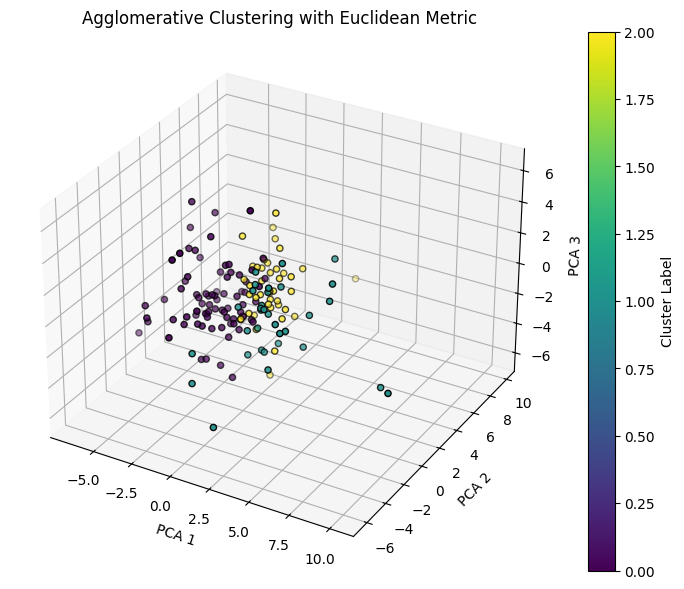

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# Assuming 'X' is your dataset ready for PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Specify clustering parameters
linkage_method = 'ward'
distance_threshold = 20.0
metric = 'euclidean'

# Perform clustering
agg_clustering = AgglomerativeClustering(linkage=linkage_method, n_clusters=None,
                                         metric=metric, distance_threshold=distance_threshold,
                                         compute_full_tree=True)
agg_clustering.fit(X_pca)
cluster_labels = agg_clustering.labels_

# Calculate and print performance metrics
silhouette = silhouette_score(X_pca, cluster_labels)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title('Agglomerative Clustering with Euclidean Metric')
plt.show()


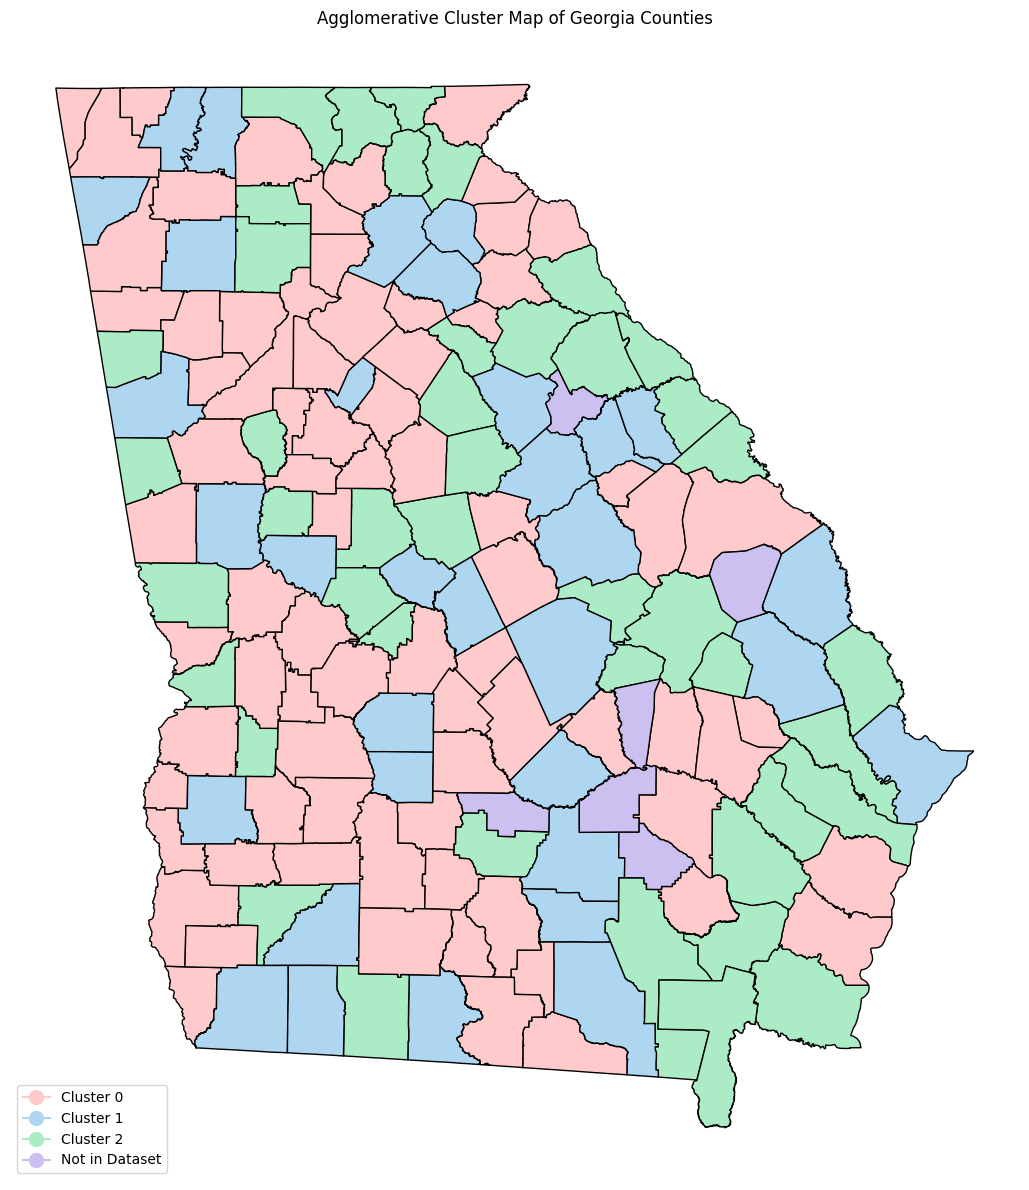

     cluster
0          0
1          1
2          2
3          0
4          1
..       ...
148        1
149        0
150        2
151        0
152        0

[153 rows x 1 columns]
cluster
0    77
1    33
2    43
dtype: int64


In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming 'geo_data' is your GeoDataFrame of Georgia counties
# Load the GeoDataFrame of Georgia counties if not already loaded
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Create a DataFrame with the cluster labels from Agglomerative Clustering
agg_cluster_df = pd.DataFrame({'County': coefficients_df_cleaned['County'], 'Cluster': cluster_labels_ward})

# Merge the geographical data with the Agglomerative Clustering cluster data
geo_data_merged = geo_data.merge(agg_cluster_df, how='left', left_on='NAME10', right_on='County')

# Determine unique clusters for color mapping, including noise
unique_clusters = np.unique(cluster_labels_ward)
color_map = {
    0: '#FFCACC',  # Color for cluster 0
    1: '#AED6F1',  # Color for cluster 1
    2: '#ABEBC6',  # Color for cluster 2
}

# Assign colors to counties based on the cluster they belong to
geo_data_merged['color'] = geo_data_merged['Cluster'].apply(lambda x: color_map.get(x, '#CCC0F1'))

# Create manual legend elements for the custom labels
legend_elements = [Line2D([0], [0], marker='o', color=color_map[cluster], label=f'Cluster {cluster}', markerfacecolor=color_map[cluster], markersize=10) for cluster in unique_clusters]
legend_elements.append(Line2D([0], [0], marker='o', color='#CCC0F1', label='Not in Dataset', markerfacecolor='#CCC0F1', markersize=10))

# Plotting the map with clusters
fig, ax = plt.subplots(1, figsize=(12, 12))
geo_data_merged.plot(color=geo_data_merged['color'], ax=ax, edgecolor='black', linewidth=1)

# Set title and axes properties
ax.set_title('Agglomerative Cluster Map of Georgia Counties')
ax.axis('off')

# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()

# Create a new dataframe with the cluster labels
df_clusters = pd.DataFrame({'cluster': cluster_labels_ward})

# Print the new dataframe
print(df_clusters)

print(df_clusters.groupby('cluster').size())


In [16]:
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
import torch_geometric
from torch_geometric.data import Data

# Original DataFrame
feature_columns = coefficients_df_cleaned.columns.drop('County')
node_features = coefficients_df_cleaned[feature_columns].values

# Perform PCA
pca = PCA(n_components=5)  # Adjust the number of components based on your requirement
pca_features = pca.fit_transform(node_features)


# Convert PCA features to PyTorch tensor
pca_features = torch.tensor(pca_features, dtype=torch.float)

# Using k-nearest neighbors to construct edges based on PCA feature similarity
k = 6  # Adjust based on your specific use case
knn_graph = kneighbors_graph(pca_features.numpy(), k, mode='connectivity', include_self=False)

# Convert csr_matrix to COO (Coordinate) format to easily extract row and column indices
coo_graph = knn_graph.tocoo()

# Extract row and column indices which represent the edges
edge_index = torch.tensor(np.vstack((coo_graph.row, coo_graph.col)), dtype=torch.long)

# Create a graph data structure suitable for PyTorch Geometric GNN models
graph_data = Data(x=pca_features, edge_index=edge_index)

# Now, 'graph_data' is ready to be used as input to GNN models

In [49]:
import torch
import numpy as np
import random

# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # for multi-GPU

# Set the seed
set_seed(42)

import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class GCNAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNAutoEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels)  # Additional layer
        self.conv4 = GCNConv(2 * out_channels, out_channels)      # Additional layer
        self.dropout = torch.nn.Dropout(0.5)
        self.decoder = torch.nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv4(x, edge_index))
        x_reconstructed = self.decoder(x)
        return x_reconstructed, x

# Define model parameters
in_channels = graph_data.x.size(1)  # Using graph_data's feature dimension
out_channels = 16  # Arbitrary, adjustable based on performance needs

# Define grid search parameters
learning_rates = [0.01, 0.05]
num_clusters_options = range(3, 6)  # Evaluating for 3 to 5 clusters
num_epochs = 500

# Store the best model results
best_silhouette = -1
best_davies_bouldin = float('inf')
best_calinski_harabasz = -1
best_params = {'lr': None, 'n_clusters': None}

for lr in learning_rates:
    for n_clusters in num_clusters_options:
        model = GCNAutoEncoder(in_channels, out_channels)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_func = torch.nn.MSELoss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            output, embeddings = model(graph_data.x, graph_data.edge_index)
            loss = loss_func(output, graph_data.x)
            loss.backward()
            optimizer.step()

        # Detach embeddings for clustering
        embeddings = embeddings.detach().numpy()
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)

        # Calculate clustering metrics
        silhouette = silhouette_score(embeddings, labels)
        davies_bouldin = davies_bouldin_score(embeddings, labels)
        calinski_harabasz = calinski_harabasz_score(embeddings, labels)

        # Update best scores
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params['lr'] = lr
            best_params['n_clusters'] = n_clusters
            best_davies_bouldin = davies_bouldin
            best_calinski_harabasz = calinski_harabasz

# Output the best parameters and scores
print(f"Best Learning Rate: {best_params['lr']}")
print(f"Best Number of Clusters: {best_params['n_clusters']}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz}")


Best Learning Rate: 0.05
Best Number of Clusters: 3
Best Silhouette Score: 0.4425744414329529
Best Davies-Bouldin Score: 0.772583335751813
Best Calinski-Harabasz Score: 109.00592492719377


Epoch 0: Loss 1.9539161920547485
Epoch 10: Loss 2.6576895713806152
Epoch 20: Loss 2.8426449298858643
Epoch 30: Loss 2.655604362487793
Epoch 40: Loss 2.3117833137512207
Epoch 50: Loss 2.095104455947876
Epoch 60: Loss 2.39072322845459
Epoch 70: Loss 2.323024272918701
Epoch 80: Loss 2.088888168334961
Epoch 90: Loss 2.752762794494629
Epoch 100: Loss 2.1634902954101562
Epoch 110: Loss 2.138293981552124
Epoch 120: Loss 2.0256714820861816
Epoch 130: Loss 2.53257417678833
Epoch 140: Loss 2.358128070831299
Epoch 150: Loss 2.0456149578094482
Epoch 160: Loss 2.245619297027588
Epoch 170: Loss 2.577819347381592
Epoch 180: Loss 2.3989014625549316
Epoch 190: Loss 2.1847329139709473
Epoch 200: Loss 2.5569820404052734
Epoch 210: Loss 2.4808340072631836
Epoch 220: Loss 2.6722264289855957
Epoch 230: Loss 2.3182098865509033
Epoch 240: Loss 2.299316167831421
Epoch 250: Loss 2.763012647628784
Epoch 260: Loss 2.2926669120788574
Epoch 270: Loss 2.3021981716156006
Epoch 280: Loss 2.712961435317993
Epoch 290: L

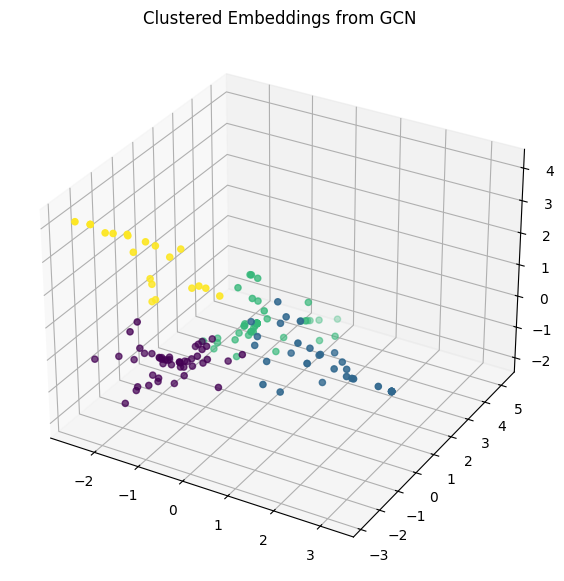

In [50]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # for multi-GPU

# Set the seed
set_seed(42)

class GCNAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNAutoEncoder, self).__init__()
        # Increase the network depth
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels)  # Additional layer
        self.conv4 = GCNConv(2 * out_channels, out_channels)      # Additional layer
        self.dropout = torch.nn.Dropout(0.5)
        self.decoder = torch.nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        # Each layer with ReLU activation and dropout
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv4(x, edge_index))
        # Decoder to reconstruct the input features
        x_reconstructed = self.decoder(x)
        return x_reconstructed, x

# Define model parameters
in_channels = graph_data.x.size(1)  # Using graph_data's feature dimension
out_channels = 16  # Arbitrary, adjustable based on performance needs

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    output, embeddings = model(graph_data.x, edge_index)
    loss = loss_func(output, graph_data.x)  # Ensure dimensionality matches
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

# Post-training operations such as clustering and evaluation here...


# After training, embeddings can be used for clustering
# Use embeddings for further analysis or clustering
# Use the last layer's output as embeddings
embeddings3 = output.detach().numpy()

# Perform KMeans clustering on embeddings
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings3)

# Evaluate clustering
silhouette = silhouette_score(embeddings3, cluster_labels)
davies_bouldin = davies_bouldin_score(embeddings3, cluster_labels)
calinski_harabasz = calinski_harabasz_score(embeddings3, cluster_labels)

print(f"Silhouette Score: {silhouette}, Davies-Bouldin Score: {davies_bouldin}, Calinski-Harabasz Score: {calinski_harabasz}")

# Visualization of the clustering
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings3[:, 0], embeddings3[:, 1], embeddings3[:, 2], c=cluster_labels, cmap='viridis')
ax.set_title('Clustered Embeddings from GCN')
plt.show()

Epoch 0: Loss 3.2478573322296143
Epoch 10: Loss 2.992466688156128
Epoch 20: Loss 3.3346216678619385
Epoch 30: Loss 3.0364882946014404
Epoch 40: Loss 3.1277637481689453
Epoch 50: Loss 3.0993850231170654
Epoch 60: Loss 3.2850987911224365
Epoch 70: Loss 3.0888009071350098
Epoch 80: Loss 2.996333122253418
Epoch 90: Loss 2.9071435928344727
Epoch 100: Loss 6.591894626617432
Epoch 110: Loss 3.5959436893463135
Epoch 120: Loss 3.4304168224334717
Epoch 130: Loss 3.183497667312622
Epoch 140: Loss 3.352083921432495
Epoch 150: Loss 3.0745081901550293
Epoch 160: Loss 3.0727593898773193
Epoch 170: Loss 3.016350507736206
Epoch 180: Loss 3.039081573486328
Epoch 190: Loss 3.0491950511932373
Epoch 200: Loss 2.888566017150879
Epoch 210: Loss 3.0999999046325684
Epoch 220: Loss 3.102820634841919
Epoch 230: Loss 3.285141944885254
Epoch 240: Loss 3.00373911857605
Epoch 250: Loss 3.1475815773010254
Epoch 260: Loss 3.0941109657287598
Epoch 270: Loss 3.3620734214782715
Epoch 280: Loss 3.107814073562622
Epoch 290

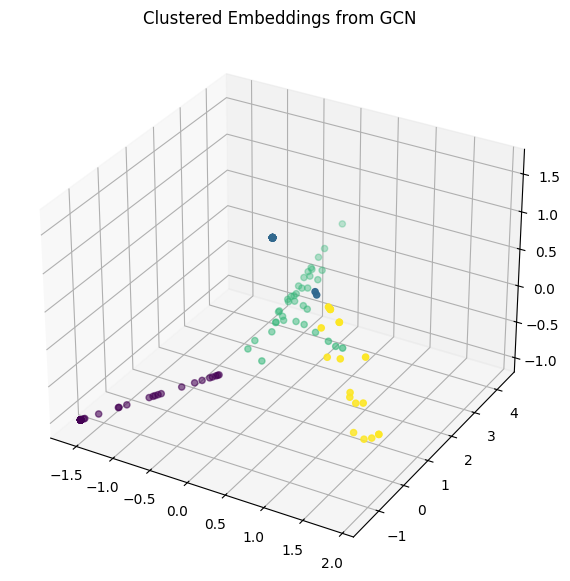

In [55]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # for multi-GPU

# Set the seed
set_seed(42)

class GCNAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNAutoEncoder, self).__init__()
        # Increase the network depth
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels)  # Additional layer
        self.conv4 = GCNConv(2 * out_channels, out_channels)      # Additional layer
        self.dropout = torch.nn.Dropout(0.5)
        self.decoder = torch.nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        # Each layer with ReLU activation and dropout
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv4(x, edge_index))
        # Decoder to reconstruct the input features
        x_reconstructed = self.decoder(x)
        return x_reconstructed, x

# Define model parameters
in_channels = graph_data.x.size(1)  # Using graph_data's feature dimension
out_channels = 32  # Arbitrary, adjustable based on performance needs

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    output, embeddings = model(graph_data.x, edge_index)
    loss = loss_func(output, graph_data.x)  # Ensure dimensionality matches
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

# Post-training operations such as clustering and evaluation here...


# After training, embeddings can be used for clustering
# Use embeddings for further analysis or clustering
# Use the last layer's output as embeddings
embeddings3 = output.detach().numpy()

# Perform KMeans clustering on embeddings
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings3)

# Evaluate clustering
silhouette = silhouette_score(embeddings3, cluster_labels)
davies_bouldin = davies_bouldin_score(embeddings3, cluster_labels)
calinski_harabasz = calinski_harabasz_score(embeddings3, cluster_labels)

print(f"Silhouette Score: {silhouette}, Davies-Bouldin Score: {davies_bouldin}, Calinski-Harabasz Score: {calinski_harabasz}")

# Visualization of the clustering
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings3[:, 0], embeddings3[:, 1], embeddings3[:, 2], c=cluster_labels, cmap='viridis')
ax.set_title('Clustered Embeddings from GCN')
plt.show()

In [56]:
print(cluster_labels)

[1 3 3 0 3 0 0 0 1 0 1 3 2 1 0 0 0 2 1 0 0 2 3 2 0 0 1 1 0 1 0 3 0 2 0 0 2
 3 2 3 0 1 2 0 0 0 0 2 2 2 1 1 1 0 0 0 2 0 0 1 1 0 3 3 0 2 3 0 2 2 0 2 0 1
 3 3 0 0 2 2 0 0 1 0 2 3 2 0 0 0 2 1 1 2 2 1 3 3 0 0 1 0 2 2 0 0 1 0 2 0 0
 1 3 0 1 2 1 0 1 1 0 0 1 0 1 1 0 0 1 2 0 2 2 2 0 0 2 2 1 0 0 2 3 1 2 0 1 2
 0 2 3 0 0]


In [57]:
import torch
import numpy as np
import random

# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # for multi-GPU

# Set the seed
set_seed(42)

import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class GCNAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNAutoEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels)  # Additional layer
        self.conv4 = GCNConv(2 * out_channels, out_channels)      # Additional layer
        self.dropout = torch.nn.Dropout(0.5)
        self.decoder = torch.nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv4(x, edge_index))
        x_reconstructed = self.decoder(x)
        return x_reconstructed, x

# Define model parameters
in_channels = graph_data.x.size(1)  # Using graph_data's feature dimension
out_channels = 32  # Arbitrary, adjustable based on performance needs

# Define grid search parameters
learning_rates = [0.01, 0.05]
num_clusters_options = range(3, 6)  # Evaluating for 3 to 5 clusters
num_epochs = 1000

# Store the best model results
best_silhouette = -1
best_davies_bouldin = float('inf')
best_calinski_harabasz = -1
best_params = {'lr': None, 'n_clusters': None}

for lr in learning_rates:
    for n_clusters in num_clusters_options:
        model = GCNAutoEncoder(in_channels, out_channels)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_func = torch.nn.MSELoss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            output, embeddings = model(graph_data.x, graph_data.edge_index)
            loss = loss_func(output, graph_data.x)
            loss.backward()
            optimizer.step()

        # Detach embeddings for clustering
        embeddings = embeddings.detach().numpy()
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)

        # Calculate clustering metrics
        silhouette = silhouette_score(embeddings, labels)
        davies_bouldin = davies_bouldin_score(embeddings, labels)
        calinski_harabasz = calinski_harabasz_score(embeddings, labels)

        # Update best scores
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params['lr'] = lr
            best_params['n_clusters'] = n_clusters
            best_davies_bouldin = davies_bouldin
            best_calinski_harabasz = calinski_harabasz

# Output the best parameters and scores
print(f"Best Learning Rate: {best_params['lr']}")
print(f"Best Number of Clusters: {best_params['n_clusters']}")
print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Davies-Bouldin Score: {best_davies_bouldin}")
print(f"Best Calinski-Harabasz Score: {best_calinski_harabasz}")


Best Learning Rate: 0.05
Best Number of Clusters: 3
Best Silhouette Score: 0.9057039022445679
Best Davies-Bouldin Score: 0.46511618992234355
Best Calinski-Harabasz Score: 4259.5634825819025


Epoch 0: Loss 4.1896796226501465
Epoch 10: Loss 3.6931254863739014
Epoch 20: Loss 3.62872314453125
Epoch 30: Loss 3.3054087162017822
Epoch 40: Loss 4.857417583465576
Epoch 50: Loss 5.986580848693848
Epoch 60: Loss 3.449322462081909
Epoch 70: Loss 3.963819742202759
Epoch 80: Loss 3.3923022747039795
Epoch 90: Loss 3.284853935241699
Epoch 100: Loss 3.1298470497131348
Epoch 110: Loss 2.9361612796783447
Epoch 120: Loss 3.257603168487549
Epoch 130: Loss 3.0857467651367188
Epoch 140: Loss 3.175586462020874
Epoch 150: Loss 2.9413697719573975
Epoch 160: Loss 2.806295871734619
Epoch 170: Loss 3.2901651859283447
Epoch 180: Loss 3.085972547531128
Epoch 190: Loss 2.9975082874298096
Epoch 200: Loss 2.878572463989258
Epoch 210: Loss 2.7657222747802734
Epoch 220: Loss 2.8525147438049316
Epoch 230: Loss 2.797600030899048
Epoch 240: Loss 2.771030902862549
Epoch 250: Loss 2.676281452178955
Epoch 260: Loss 3.810563564300537
Epoch 270: Loss 3.005681037902832
Epoch 280: Loss 3.1087772846221924
Epoch 290: Lo

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


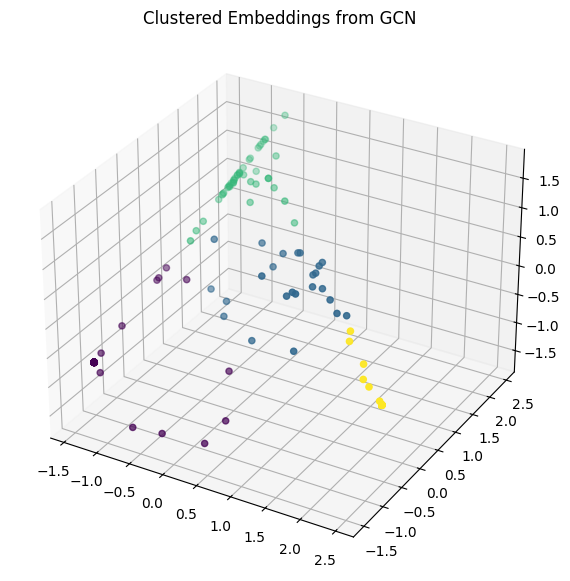

In [17]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # for multi-GPU

# Set the seed
set_seed(42)

class GCNAutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNAutoEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels)
        self.conv3 = GCNConv(2 * out_channels, 2 * out_channels)  # Additional layer
        self.conv4 = GCNConv(2 * out_channels, out_channels)      # Additional layer
        self.dropout = torch.nn.Dropout(0.5)
        self.decoder = torch.nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv4(x, edge_index))
        x_reconstructed = self.decoder(x)
        return x_reconstructed, x

# Initialize model
in_channels = graph_data.x.size(1)  # Using graph_data's feature dimension
out_channels = 64  # Arbitrary, adjustable based on performance needs
model = GCNAutoEncoder(in_channels, out_channels)

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    output, embeddings4 = model(graph_data.x, graph_data.edge_index)
    loss = loss_func(output, graph_data.x)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

embeddings4 = output.detach().numpy()

# Perform KMeans clustering on embeddings
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels4 = kmeans.fit_predict(embeddings4)

# Evaluate clustering
silhouette = silhouette_score(embeddings4, cluster_labels4)
davies_bouldin = davies_bouldin_score(embeddings4, cluster_labels4)
calinski_harabasz = calinski_harabasz_score(embeddings4, cluster_labels4)

print(f"Silhouette Score: {silhouette}, Davies-Bouldin Score: {davies_bouldin}, Calinski-Harabasz Score: {calinski_harabasz}")

# Visualization of the clustering
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings4[:, 0], embeddings4[:, 1], embeddings4[:, 2], c=cluster_labels4, cmap='viridis')
ax.set_title('Clustered Embeddings from GCN')
plt.show()


In [5]:

# import pandas as pd
# # Convert the embeddings and cluster labels into a dataframe
# df_to_save = pd.DataFrame(embeddings4)
# df_to_save['cluster_labels'] = cluster_labels4

# # Define the file path
# file_path = './gcn_embeddings_and_clusters.csv'

# # Save the dataframe as a CSV file
# df_to_save.to_csv(file_path, index=False)



import pandas as pd 

df_loaded = pd.read_csv("./gcn_embeddings_and_clusters.csv")

embeddings4_loaded = df_loaded.drop("cluster_labels", axis=1).values
cluster_labels_loaded = df_loaded["cluster_labels"].values

#print(embeddings4_loaded)
print(cluster_labels_loaded)

[2 3 2 0 3 1 0 0 1 0 3 1 2 1 0 0 0 3 2 0 0 2 3 2 3 1 2 2 0 3 0 3 0 2 0 0 2
 1 2 3 0 3 2 0 0 0 0 2 1 2 2 2 0 1 0 0 0 0 0 2 1 0 3 3 0 2 3 0 2 1 0 2 0 1
 1 3 0 0 3 1 0 0 1 2 1 2 2 0 0 0 2 2 2 2 3 2 3 2 1 3 1 0 2 2 3 2 3 0 2 0 0
 1 3 0 1 3 3 0 3 1 0 0 2 1 2 1 1 0 2 3 0 2 3 2 0 0 2 1 3 0 0 0 3 3 2 0 2 2
 3 2 3 2 0]


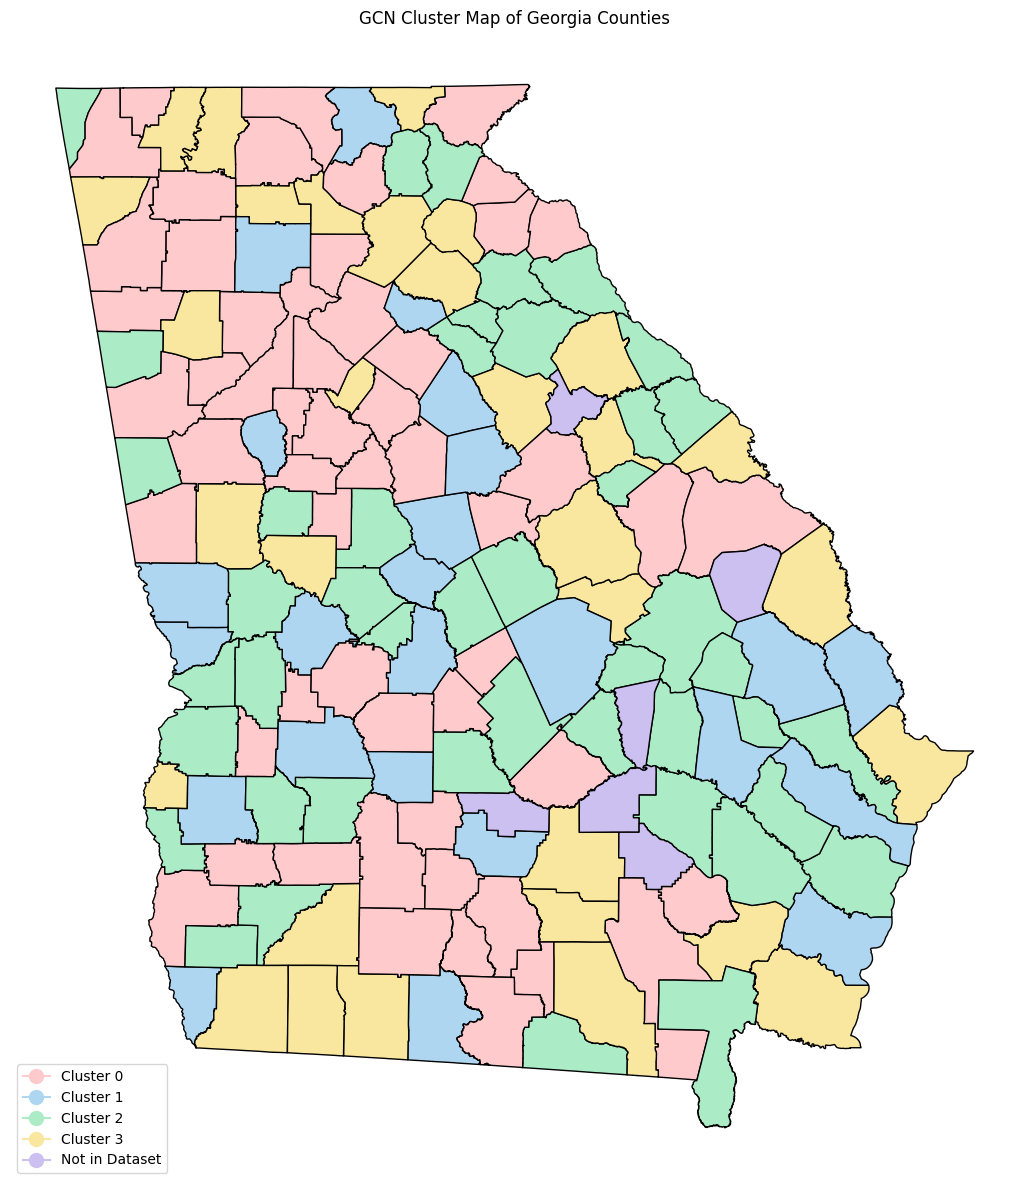

     cluster
0          2
1          3
2          2
3          0
4          3
..       ...
148        3
149        2
150        3
151        2
152        0

[153 rows x 1 columns]
cluster
0    54
1    24
2    44
3    31
dtype: int64


In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

# Assuming 'geo_data' is your GeoDataFrame of Georgia counties
# Load the GeoDataFrame of Georgia counties if not already loaded
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')

# Create a DataFrame with the cluster labels from GCN
gcn_cluster_df = pd.DataFrame({'County': coefficients_df_cleaned['County'], 'Cluster': cluster_labels_loaded})

# Merge the geographical data with the GCN Clustering cluster data
geo_data_merged = geo_data.merge(gcn_cluster_df, how='left', left_on='NAME10', right_on='County')

# Determine unique clusters for color mapping
unique_clusters = np.unique(cluster_labels_loaded)
color_map = {
    0: '#FFCACC',  # Color for cluster 0
    1: '#AED6F1',  # Color for cluster 1
    2: '#ABEBC6',  # Color for cluster 2
    3: '#F9E79F'   # Color for cluster 3, assuming cluster 3 exists
}

# Assign colors to counties based on the cluster they belong to
geo_data_merged['color'] = geo_data_merged['Cluster'].apply(lambda x: color_map.get(x, '#CCC0F1'))  # Default light purple for counties not in the dataset

# Create manual legend elements for the custom labels
legend_elements = [Line2D([0], [0], marker='o', color=color_map[cluster], label=f'Cluster {cluster}', markerfacecolor=color_map[cluster], markersize=10) for cluster in unique_clusters]
legend_elements.append(Line2D([0], [0], marker='o', color='#CCC0F1', label='Not in Dataset', markerfacecolor='#CCC0F1', markersize=10))

# Plotting the map with clusters
fig, ax = plt.subplots(1, figsize=(12, 12))
geo_data_merged.plot(color=geo_data_merged['color'], ax=ax, edgecolor='black', linewidth=1)

# Set title and axes properties
ax.set_title('GCN Cluster Map of Georgia Counties')
ax.axis('off')

# Add the custom legend to the map
ax.legend(handles=legend_elements, loc='lower left')

plt.tight_layout()
plt.show()

# Create a new dataframe with the cluster labels
df_clusters = pd.DataFrame({'cluster': cluster_labels_loaded})

# Print the new dataframe
print(df_clusters)

# Print the size of each cluster
print(df_clusters.groupby('cluster').size())


In [18]:
# After performing KMeans clustering as you did
centroids = kmeans.cluster_centers_

# Convert the centroids to a DataFrame for better readability and potential further analysis
import pandas as pd
centroids_df = pd.DataFrame(centroids, columns=[f'PCA Component #{i+1}' for i in range(centroids.shape[1])])

# Display the centroids
print(centroids_df)


   PCA Component #1  PCA Component #2  PCA Component #3  PCA Component #4  \
0         -1.262782         -1.005743         -0.832596         -0.330864   
1          0.721165          0.144956          0.464642          0.279996   
2         -0.752575          1.615019          1.040299          0.075066   
3          2.393904         -0.499299         -0.476336          0.538262   

   PCA Component #5  
0         -0.166918  
1          0.123198  
2          0.097771  
3          0.443620  


In [20]:
import pandas as pd
import numpy as np

features = coefficients_df_cleaned.columns.drop('County') 

# Example centroids array from KMeans
centroids = kmeans.cluster_centers_

# Assuming 'loadings' is the DataFrame from PCA with components as columns
loadings = pd.DataFrame(pca.components_.T, columns=[f'PCA Component #{i+1}' for i in range(pca.n_components_)], index=features)

# Create a DataFrame to hold the profile of each cluster
cluster_profiles = pd.DataFrame(index=loadings.index)

# Map each centroid back to the original features using the loadings
for i, centroid in enumerate(centroids):
    profile = loadings.multiply(centroid, axis=1).sum(axis=1)  # Weighted sum of loadings by centroid coordinates
    cluster_profiles[f'Cluster {i+1} Profile'] = profile

# Now cluster_profiles DataFrame holds the weighted profile of original features for each cluster
print(cluster_profiles)


                                                Cluster 1 Profile  \
Pct_Children_in_Poverty_a                               -0.181959   
Pct_Children_in_Poverty_b                                0.181902   
Pct_Children_in_Poverty_c                               -0.181846   
Pct_Excessive_Drinking_a                                 0.104085   
Pct_Excessive_Drinking_b                                -0.104093   
Pct_Excessive_Drinking_c                                 0.104100   
Pct_Smokers_a                                           -0.126377   
Pct_Smokers_b                                            0.126435   
Pct_Smokers_c                                           -0.126493   
Pct_Unemployed_a                                         0.306168   
Pct_Unemployed_b                                        -0.306196   
Pct_Unemployed_c                                         0.306225   
Pct_Uninsured_a                                         -0.435720   
Pct_Uninsured_b                   

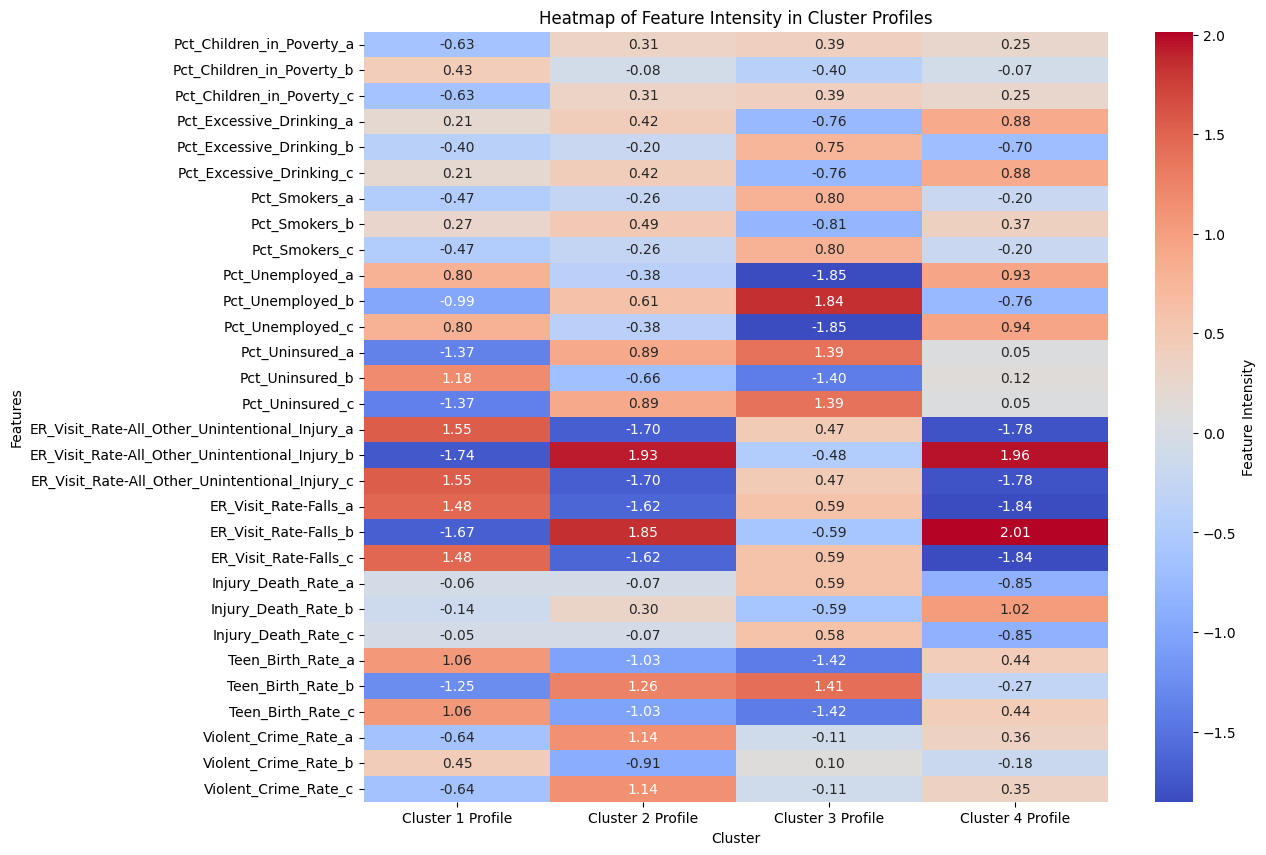

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the cluster_profiles for better visualization
cluster_profiles_normalized = cluster_profiles.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Create a heatmap of the cluster profiles
plt.figure(figsize=(12, 10))
sns.heatmap(cluster_profiles_normalized, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Feature Intensity'})
plt.title('Heatmap of Feature Intensity in Cluster Profiles')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()


In [24]:
from scipy.stats import f_oneway

# Assuming 'coefficients_df_cleaned' has a column named 'ER_Visit_Rate-All_Other_Unintentional_Injury_b' which is the feature of interest
# and a column 'Cluster' that contains the cluster labels from your GCN model
coefficients_df_cleaned['Cluster'] = cluster_labels_loaded


# Perform ANOVA across clusters
anova_results = f_oneway(
    *[coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster]['ER_Visit_Rate-All_Other_Unintentional_Injury_b'] 
      for cluster in coefficients_df_cleaned['Cluster'].unique()]
)

# Output the F-statistic and the p-value
print('F-Statistic:', anova_results.statistic)
print('p-value:', anova_results.pvalue)

# Determine if you should reject the null hypothesis
if anova_results.pvalue < 0.05:
    print("We reject the null hypothesis: there is a significant difference in means across clusters.")
else:
    print("We fail to reject the null hypothesis: there is no significant difference in means across clusters.")


F-Statistic: 35.56484576738994
p-value: 2.1478876111172975e-17
We reject the null hypothesis: there is a significant difference in means across clusters.


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15995/1385958002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels_loaded


In [25]:
from scipy.stats import f_oneway
import pandas as pd

# Let's say 'features' is the list of column names for the features
# Exclude 'Cluster' and 'County' column from the features list if present
features = coefficients_df_cleaned.columns.drop(['Cluster', 'County'])

# Initialize an empty list to hold the results
anova_results_list = []

# Loop through each feature and perform ANOVA
for feature in features:
    # Get the groups based on clusters
    groups = [coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster][feature] for cluster in coefficients_df_cleaned['Cluster'].unique()]
    # Perform ANOVA
    f_statistic, p_value = f_oneway(*groups)
    
    # Determine if the null hypothesis can be rejected
    reject_null = p_value < 0.05
    
    # Append results to the list
    anova_results_list.append({'Feature': feature, 'F-Statistic': f_statistic, 'p-value': p_value, 'Reject Null': reject_null})

# Create a DataFrame from the results list
anova_results_df = pd.DataFrame(anova_results_list)

# Print the DataFrame
print(anova_results_df)

# Optional: Save the results to a CSV file
anova_results_df.to_csv('./anova_results.csv', index=False)


                                           Feature  F-Statistic       p-value  \
0                        Pct_Children_in_Poverty_a     0.614362  6.067218e-01   
1                        Pct_Children_in_Poverty_b     0.613675  6.071624e-01   
2                        Pct_Children_in_Poverty_c     0.613042  6.075690e-01   
3                         Pct_Excessive_Drinking_a     4.764049  3.354395e-03   
4                         Pct_Excessive_Drinking_b     4.764882  3.350806e-03   
5                         Pct_Excessive_Drinking_c     4.765703  3.347273e-03   
6                                    Pct_Smokers_a     1.991170  1.177803e-01   
7                                    Pct_Smokers_b     1.992402  1.175979e-01   
8                                    Pct_Smokers_c     1.993643  1.174144e-01   
9                                 Pct_Unemployed_a    10.045844  4.541819e-06   
10                                Pct_Unemployed_b    10.046866  4.536213e-06   
11                          

In [27]:
from tabulate import tabulate

# Convert your ANOVA results DataFrame into a pretty-printed table
pretty_table = tabulate(anova_results_df, headers='keys', tablefmt='pretty', showindex=False)

# Print the table
print(pretty_table)


+------------------------------------------------+--------------------+------------------------+-------------+
|                    Feature                     |    F-Statistic     |        p-value         | Reject Null |
+------------------------------------------------+--------------------+------------------------+-------------+
|           Pct_Children_in_Poverty_a            | 0.6143617250839678 |   0.6067218448024926   |    False    |
|           Pct_Children_in_Poverty_b            | 0.6136752196636893 |   0.6071623527844064   |    False    |
|           Pct_Children_in_Poverty_c            | 0.6130417176763427 |   0.6075690371867866   |    False    |
|            Pct_Excessive_Drinking_a            | 4.764048636155111  |  0.003354395000546533  |    True     |
|            Pct_Excessive_Drinking_b            | 4.7648816978846975 | 0.0033508058321099726  |    True     |
|            Pct_Excessive_Drinking_c            | 4.765702557231728  |  0.003347273011096267  |    True     |
|

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for significant features where the null hypothesis was rejected
significant_features = anova_results_df[anova_results_df['Reject Null']]['Feature'].tolist()

# Create a DataFrame that includes the cluster labels and the significant features
df_significant = coefficients_df_cleaned[['Cluster'] + significant_features]



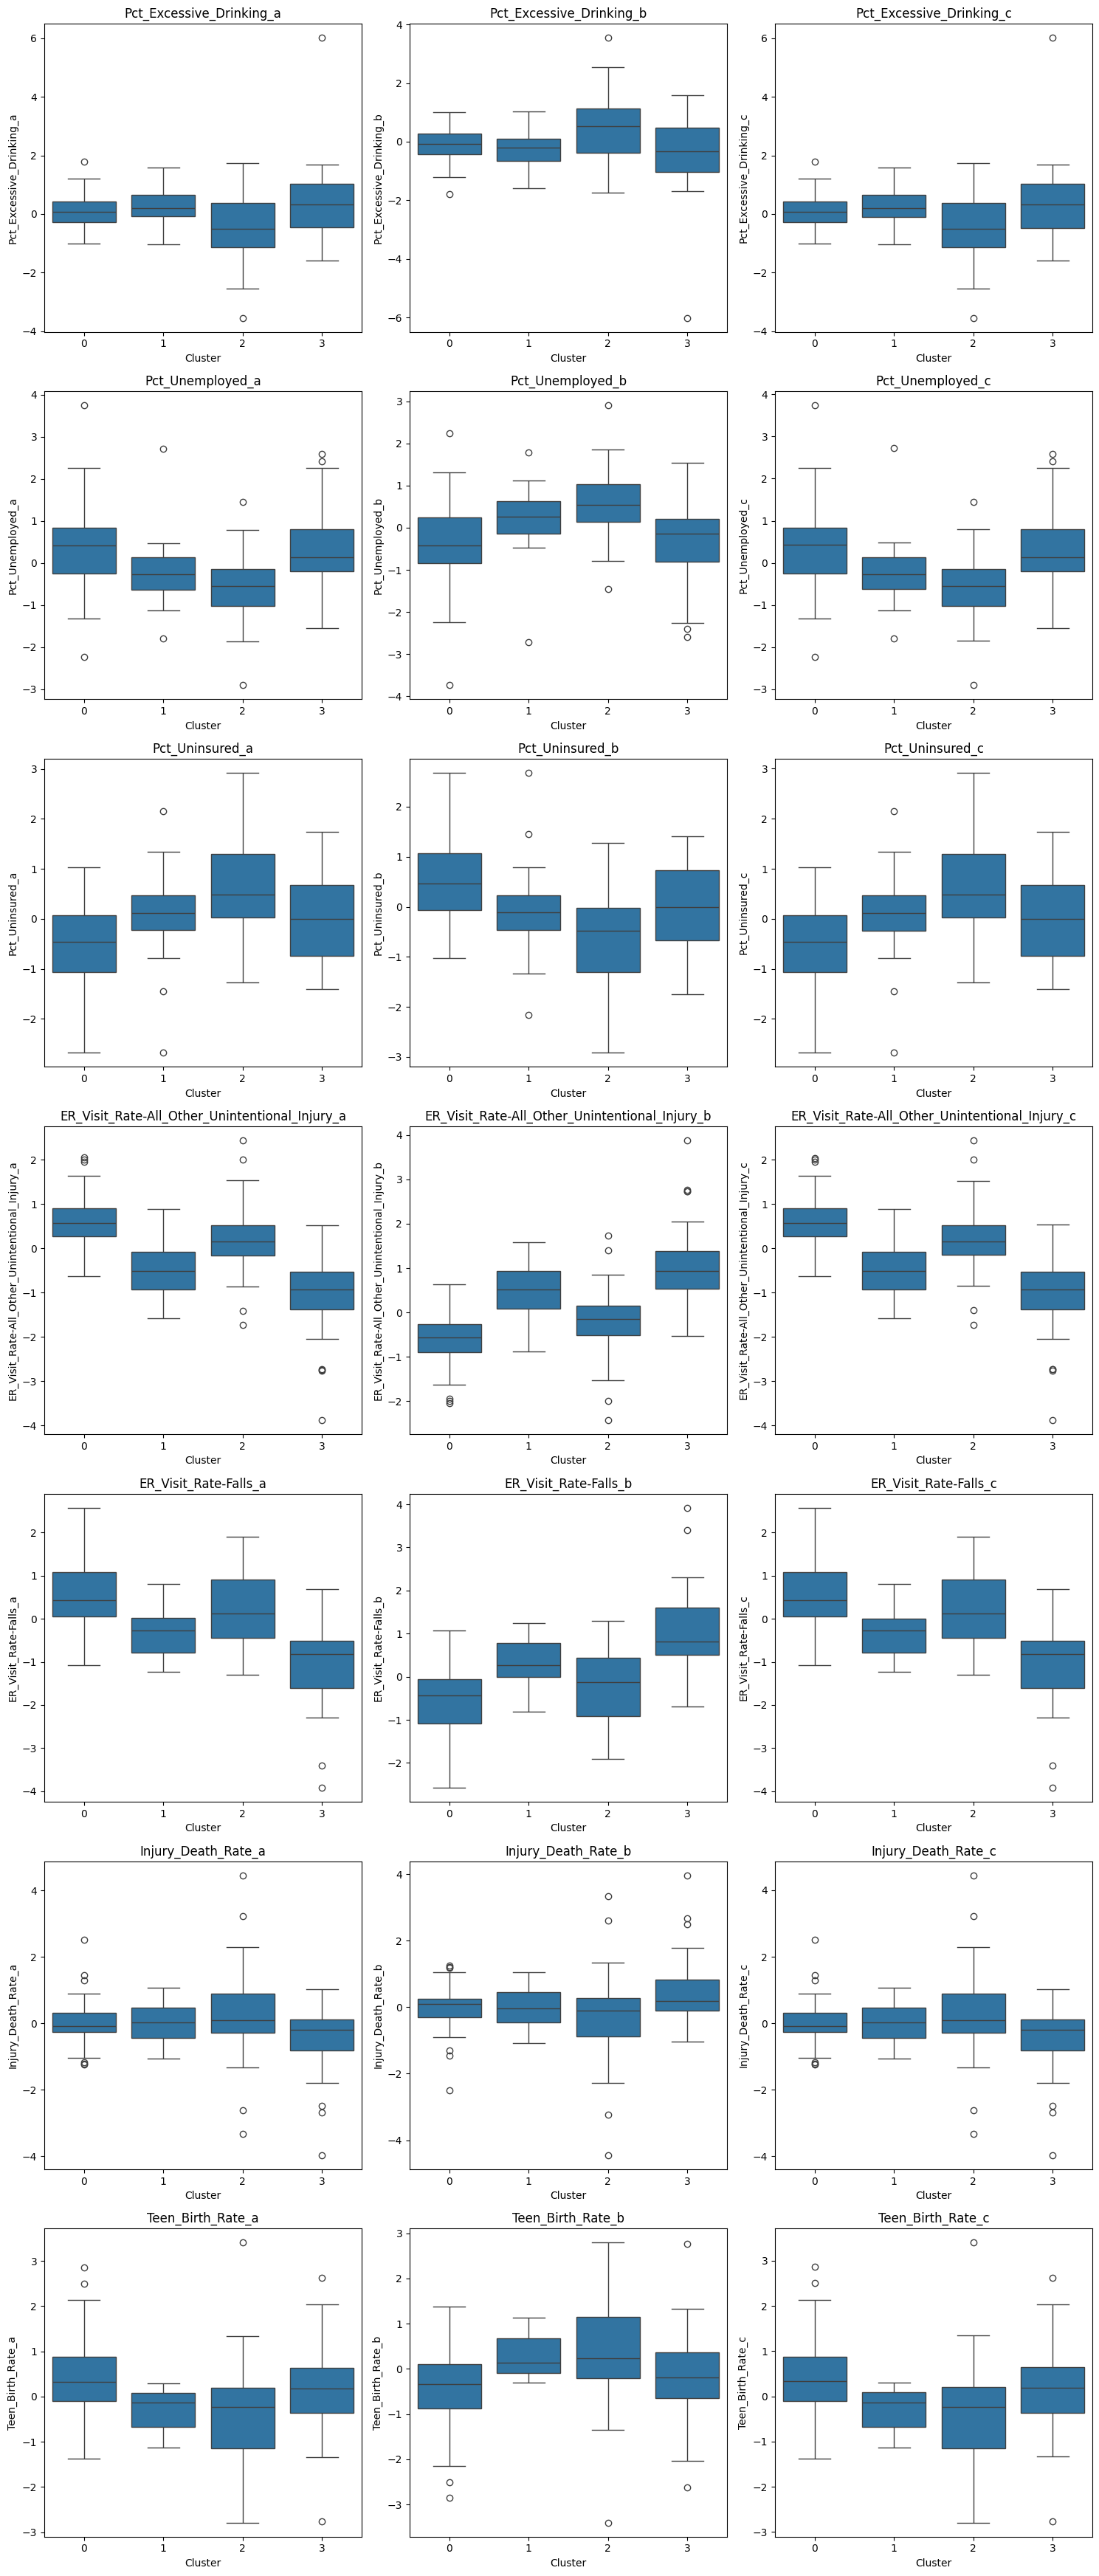

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'significant_features' is your list of features where the null hypothesis was rejected
num_features = len(significant_features)
num_columns = 3  # Number of columns in the grid
num_rows = (num_features + num_columns - 1) // num_columns  # Calculate rows needed, rounding up

# Create a large figure to hold the subplots
plt.figure(figsize=(15, 5 * num_rows))

# Iterate over the significant features to create a subplot for each
for i, feature in enumerate(significant_features, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(x='Cluster', y=feature, data=coefficients_df_cleaned)
    plt.title(feature)
    plt.tight_layout()

plt.show()


In [30]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Assuming 'coefficients_df_cleaned' is your DataFrame and 'significant_features' lists the features of interest
clusters = coefficients_df_cleaned['Cluster'].unique()
overall_means = coefficients_df_cleaned[significant_features].mean()

cluster_descriptions = {}

for cluster in sorted(clusters):
    cluster_data = coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster]
    cluster_means = cluster_data[significant_features].mean()
    
    # Initialize lists to store high and low significant features
    significant_high = []
    significant_low = []
    
    # Perform t-tests and determine significance
    for feature in significant_features:
        stat, p_value = ttest_1samp(cluster_data[feature], overall_means[feature])
        
        # Consider the feature significant if p-value < 0.05
        if p_value < 0.05:
            if cluster_means[feature] > overall_means[feature]:
                significant_high.append(feature)
            elif cluster_means[feature] < overall_means[feature]:
                significant_low.append(feature)
    
    # Forming the profile description
    description = f"Cluster {cluster} characteristics:\n"
    if significant_high:
        description += f"Significantly higher in: {', '.join(significant_high)}\n"
    if significant_low:
        description += f"Significantly lower in: {', '.join(significant_low)}\n"
    
    cluster_descriptions[cluster] = description

# Print all cluster descriptions
for cluster, description in cluster_descriptions.items():
    print(description)


Cluster 0 characteristics:
Significantly higher in: Pct_Unemployed_a, Pct_Unemployed_c, Pct_Uninsured_b, ER_Visit_Rate-All_Other_Unintentional_Injury_a, ER_Visit_Rate-All_Other_Unintentional_Injury_c, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_c, Teen_Birth_Rate_a, Teen_Birth_Rate_c
Significantly lower in: Pct_Unemployed_b, Pct_Uninsured_a, Pct_Uninsured_c, ER_Visit_Rate-All_Other_Unintentional_Injury_b, ER_Visit_Rate-Falls_b, Teen_Birth_Rate_b

Cluster 1 characteristics:
Significantly higher in: ER_Visit_Rate-All_Other_Unintentional_Injury_b, ER_Visit_Rate-Falls_b, Teen_Birth_Rate_b
Significantly lower in: ER_Visit_Rate-All_Other_Unintentional_Injury_a, ER_Visit_Rate-All_Other_Unintentional_Injury_c, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_c, Teen_Birth_Rate_a, Teen_Birth_Rate_c

Cluster 2 characteristics:
Significantly higher in: Pct_Excessive_Drinking_b, Pct_Unemployed_b, Pct_Uninsured_a, Pct_Uninsured_c, Teen_Birth_Rate_b
Significantly lower in: Pct_Excessive_Drinking_a, Pct_Exc

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Assuming 'coefficients_df_cleaned' is your DataFrame and 'significant_features' lists the features of interest
clusters = coefficients_df_cleaned['Cluster'].unique()
overall_means = coefficients_df_cleaned[significant_features].mean()

# Prepare data for the table
table_data = []

for cluster in sorted(clusters):
    cluster_data = coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster]
    cluster_means = cluster_data[significant_features].mean()
    
    # Initialize lists to store high and low significant features
    significant_high = []
    significant_low = []
    
    # Perform t-tests and determine significance
    for feature in significant_features:
        stat, p_value = ttest_1samp(cluster_data[feature], overall_means[feature])
        
        # Consider the feature significant if p-value < 0.05
        if p_value < 0.05:
            if cluster_means[feature] > overall_means[feature]:
                significant_high.append(feature)
            elif cluster_means[feature] < overall_means[feature]:
                significant_low.append(feature)
    
    # Forming the profile description
    high_features = ', '.join(significant_high)
    low_features = ', '.join(significant_low)
    
    # Append to table data
    table_data.append([cluster, high_features, low_features])

# Create DataFrame
df_table = pd.DataFrame(table_data, columns=['Cluster', 'Significantly Higher Features', 'Significantly Lower Features'])

# Apply styling
styled_table = df_table.style.set_table_styles(
    [{'selector': 'th',
      'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', 'black'), ('background-color', 'lightgrey')]},
     {'selector': 'td',
      'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ]
).background_gradient(cmap='viridis')  # or use any other colormap

# Export to HTML (correct method)
html = styled_table.to_html()

# Save to HTML file
with open('styled_table.html', 'w') as f:
    f.write(html)

# If you are using Jupyter Notebook, display it directly
styled_table


In [42]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Dictionary to store post-hoc results
post_hoc_results = {}

for feature in significant_features:
    # Prepare the data for Tukey's test
    tukey_data = coefficients_df_cleaned[[feature, 'Cluster']].dropna()
    tukey_result = pairwise_tukeyhsd(endog=tukey_data[feature], groups=tukey_data['Cluster'], alpha=0.05)
    post_hoc_results[feature] = tukey_result.summary()
    
    # Optionally print results for each feature
    print(f"Post-Hoc Analysis for {feature}:\n", tukey_result)


Post-Hoc Analysis for ER_Visit_Rate-All_Other_Unintentional_Injury_a:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -1.1514    0.0 -1.6396 -0.6633   True
     0      2  -0.4494 0.0228 -0.8535 -0.0453   True
     0      3  -1.6647    0.0  -2.113 -1.2163   True
     1      2    0.702 0.0023  0.1971   1.207   True
     1      3  -0.5132 0.0697 -1.0543  0.0278  False
     2      3  -1.2153    0.0 -1.6819 -0.7487   True
----------------------------------------------------
Post-Hoc Analysis for ER_Visit_Rate-All_Other_Unintentional_Injury_b:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   1.1513    0.0  0.6632  1.6394   True
     0      2   0.4493 0.0228  0.0452  0.8533   True
     0      3    1.665    0.0  1.2167  2.1133   True
     1    

/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15995/3608346778.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}


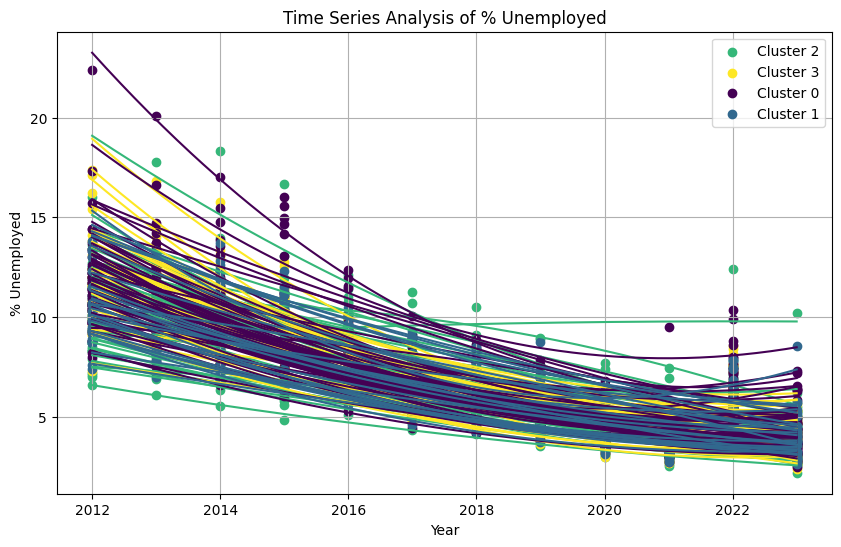

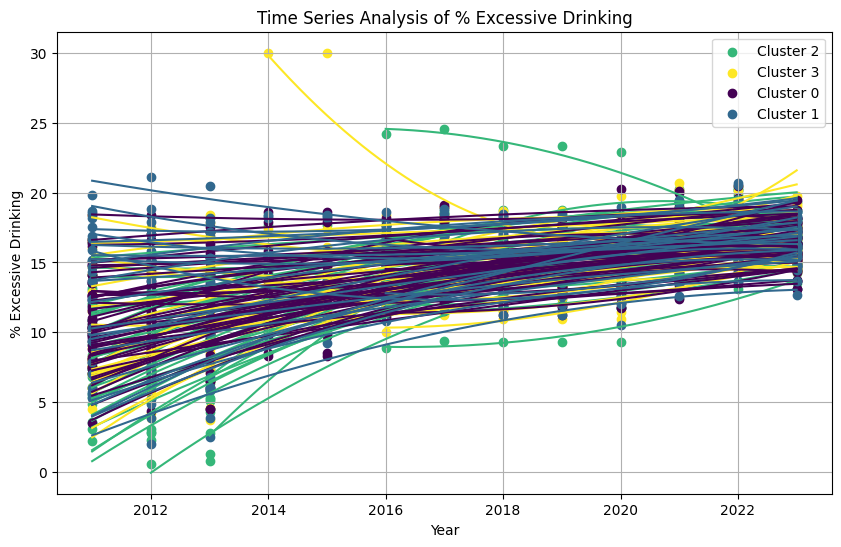

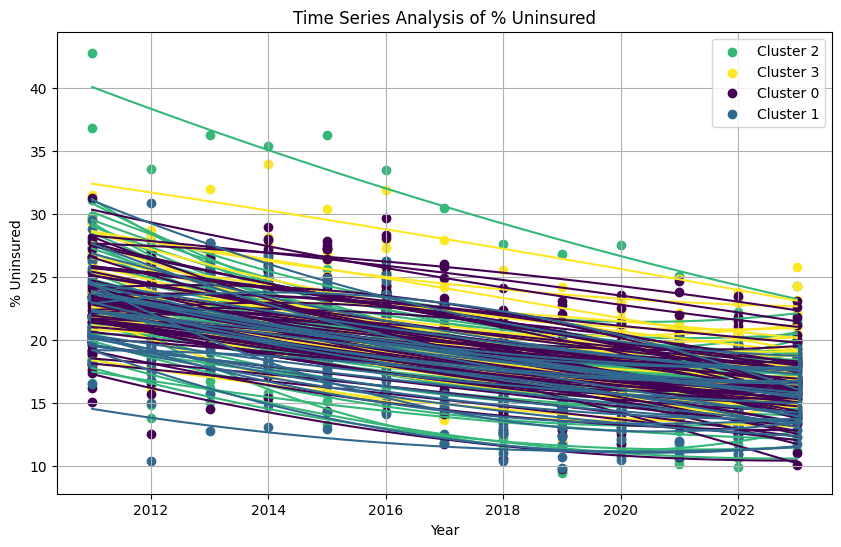

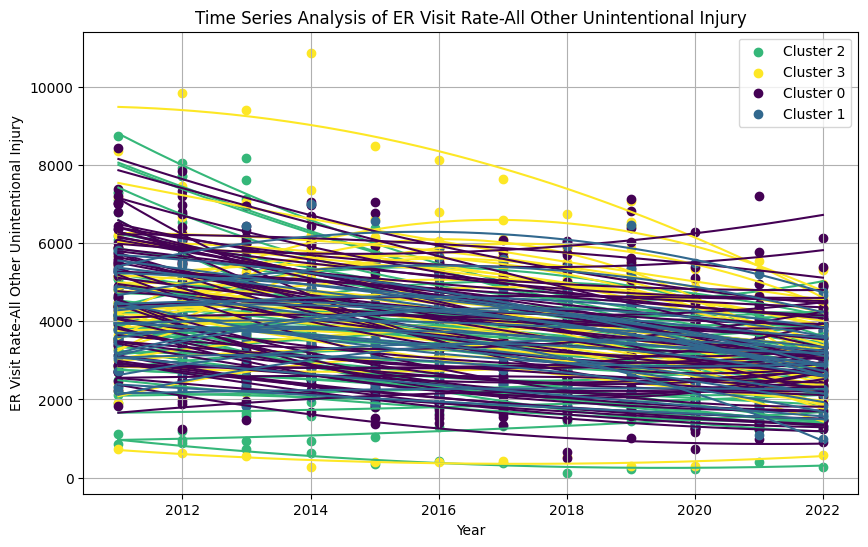

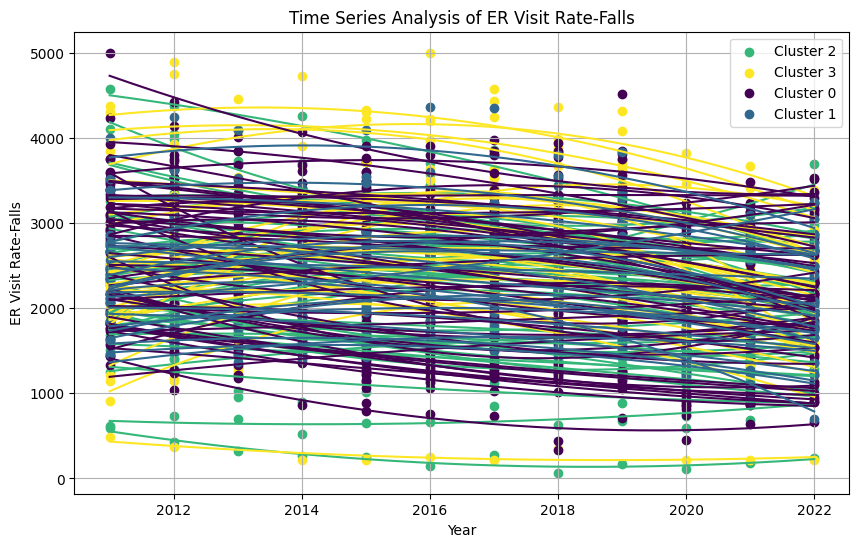

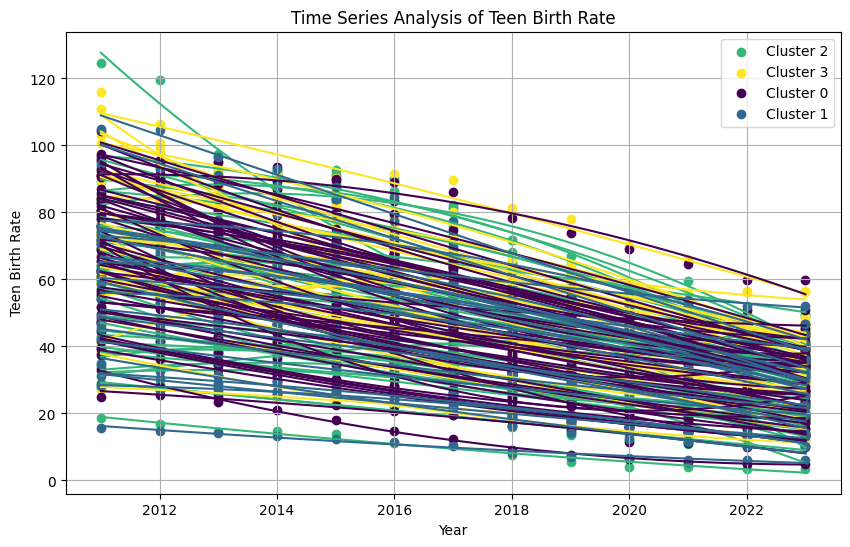

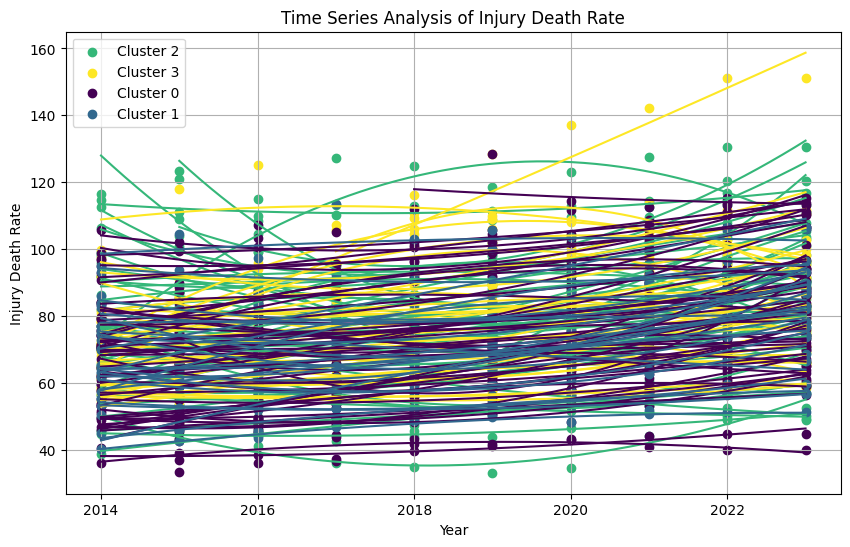

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


# Load the county data for year-wise analysis
cleaned_data_table = pd.read_csv("pivot_wide_format_data_cleaned.csv")
filtered_data_table = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.3].copy()

# Define significant features
significant_features = [
    'Pct_Unemployed_a', 'Pct_Unemployed_b'  # Example features, replace with actual features
]

# Define the color map for clusters
clusters = coefficients_df_cleaned['Cluster'].unique()
cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}

# Modify the plotting function to adjust the legend
def plot_feature_by_year_with_regression(data, feature_name):
    plt.figure(figsize=(10, 6))
    legend_labels = {}  # To track legend labels and avoid duplicates
    for cluster in clusters:
        cluster_counties = coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster]['County'].unique()
        
        for county in cluster_counties:
            county_data = data[data['County'] == county]
            county_data = county_data.dropna(subset=[feature_name, 'Year'])

            if not county_data.empty:
                # Scatter plot
                label = f"Cluster {cluster}" if cluster not in legend_labels else ""
                plt.scatter(county_data['Year'], county_data[feature_name], color=cluster_color_map[cluster], label=label)
                legend_labels[cluster] = True  # Mark this cluster as labeled

                # Quadratic regression
                X = county_data['Year'].values.reshape(-1, 1)
                Y = county_data[feature_name]
                model = make_pipeline(PolynomialFeatures(2), LinearRegression())
                model.fit(X, Y)
                X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
                plt.plot(X_seq, model.predict(X_seq), color=cluster_color_map[cluster])
                
    plt.title(f"Time Series Analysis of {feature_name}")
    plt.xlabel("Year")
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.show()


original_features = ["% Unemployed", "% Excessive Drinking", "% Uninsured", "ER Visit Rate-All Other Unintentional Injury", "ER Visit Rate-Falls", 
                     "Teen Birth Rate", "Injury Death Rate"]
# Plot each significant feature for year-wise analysis
for feature in original_features:
    plot_feature_by_year_with_regression(filtered_data_table, feature)


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15995/2293361950.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}


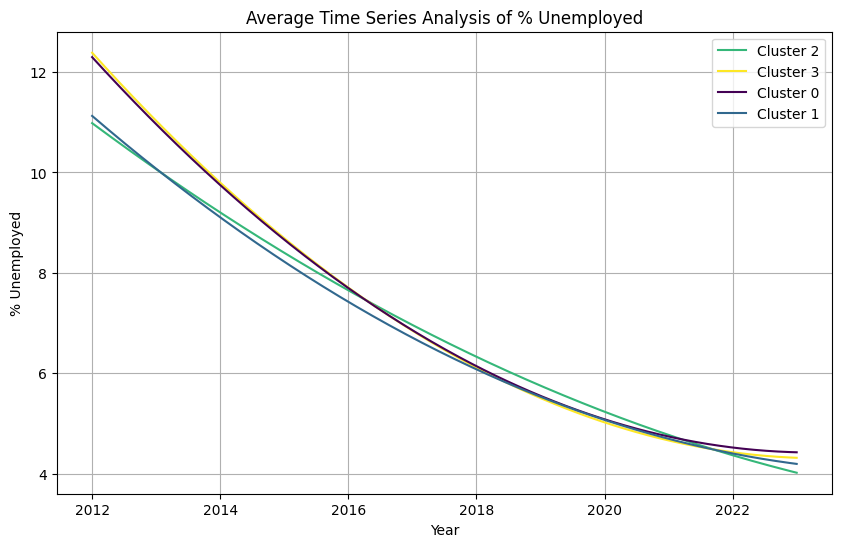

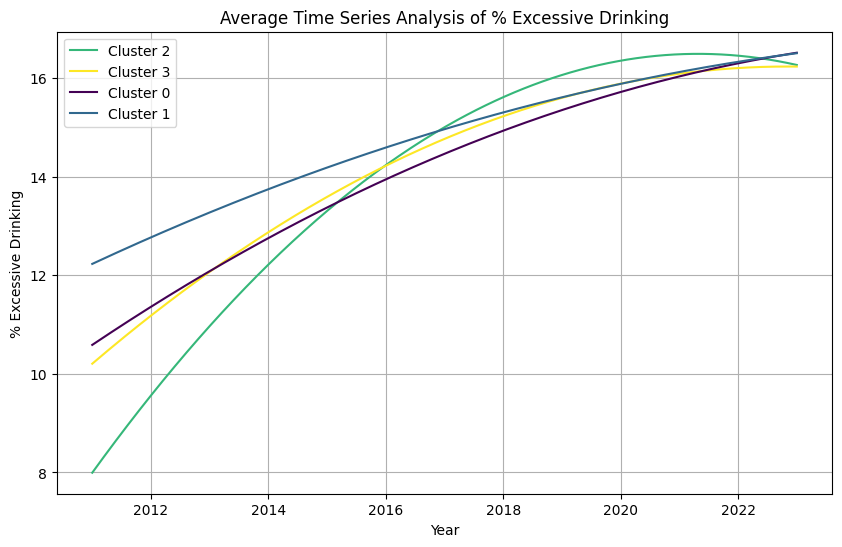

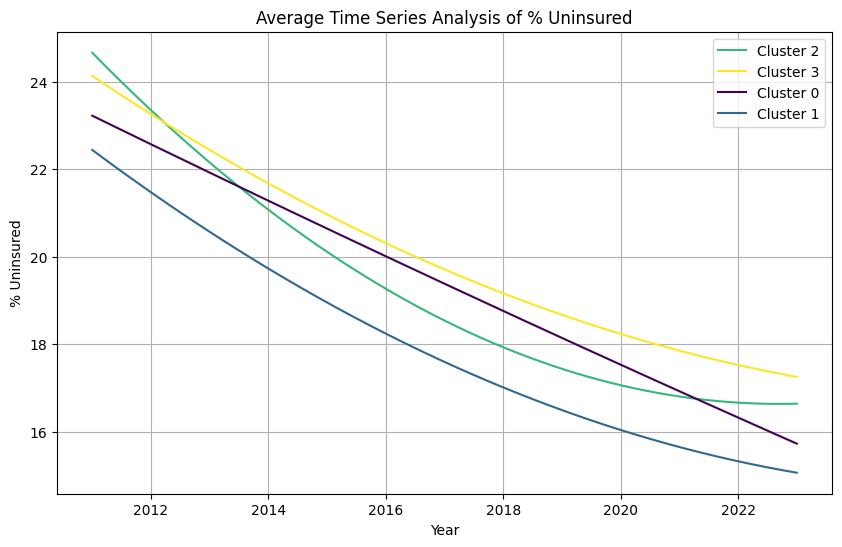

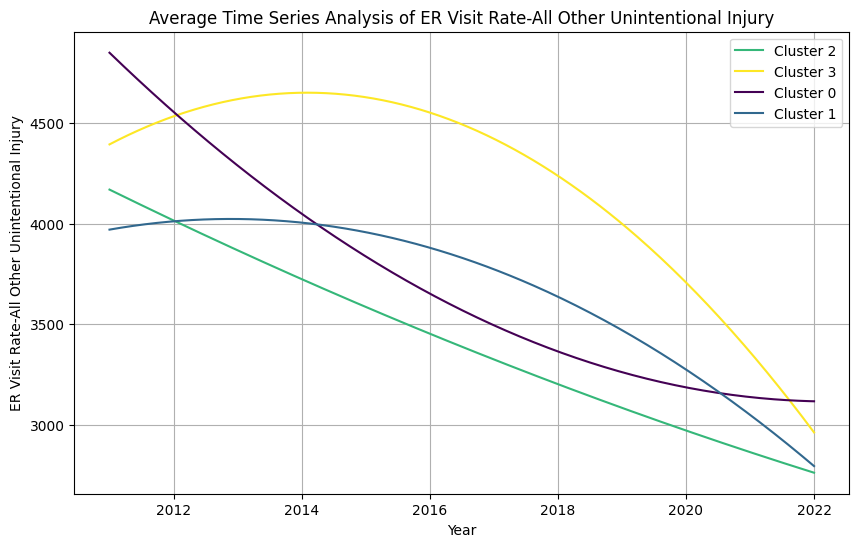

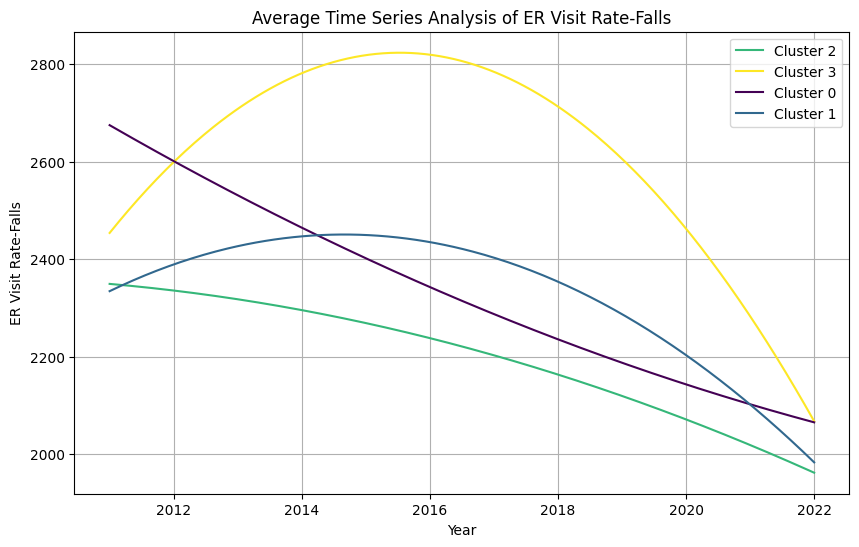

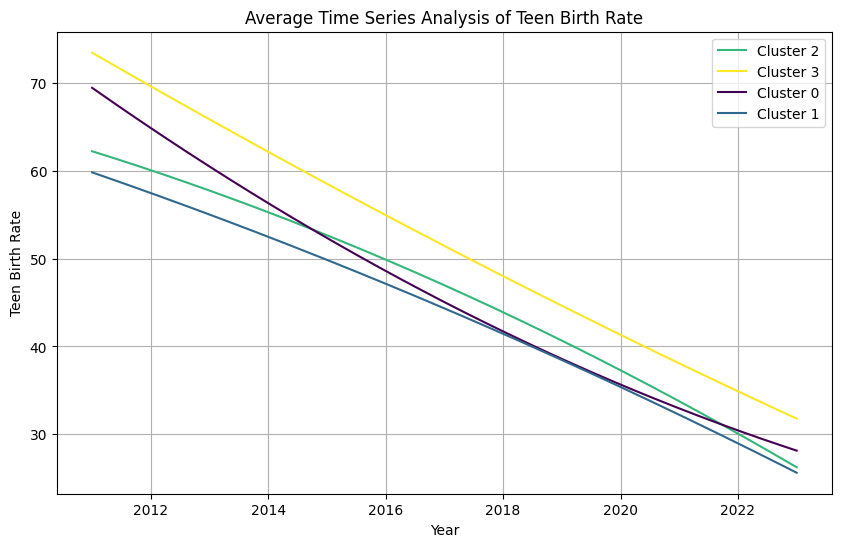

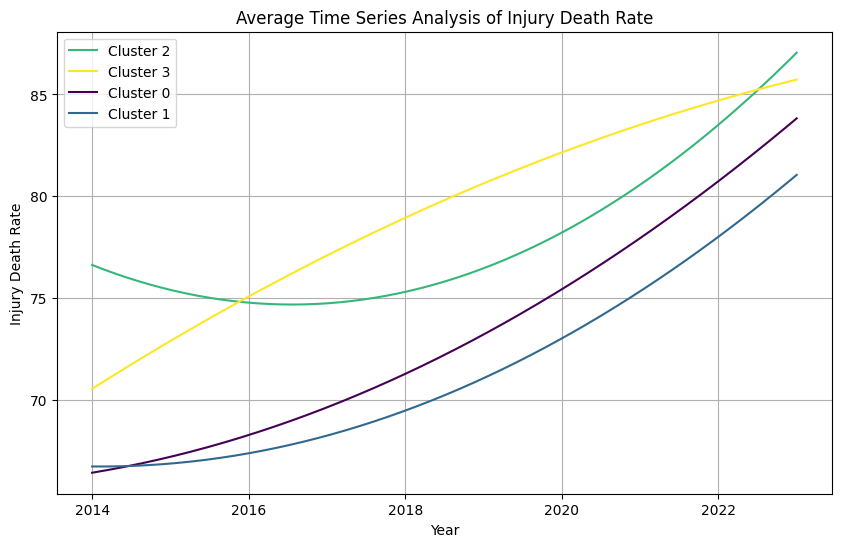

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Load the county data for year-wise analysis
cleaned_data_table = pd.read_csv("pivot_wide_format_data_cleaned.csv")
filtered_data_table = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.3].copy()
filtered_data_table = filtered_data_table.merge(coefficients_df_cleaned[['County', 'Cluster']], on='County', how='left')


# Define the color map for clusters
clusters = coefficients_df_cleaned['Cluster'].unique()
cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}

def plot_average_by_cluster(data, feature_name):
    plt.figure(figsize=(10, 6))
    legend_added = set()
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        
        # Drop any rows where 'feature_name' is NaN
        mean_data = mean_data.dropna(subset=[feature_name])

        if not mean_data.empty:
            X = mean_data['Year'].values.reshape(-1, 1)
            Y = mean_data[feature_name].values
            model = make_pipeline(PolynomialFeatures(2), LinearRegression())
            model.fit(X, Y)
            X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            plt.plot(X_seq, model.predict(X_seq), label=f"Cluster {cluster}" if cluster not in legend_added else "", color=cluster_color_map[cluster])
            legend_added.add(cluster)

    plt.title(f"Average Time Series Analysis of {feature_name}")
    plt.xlabel("Year")
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.show()

original_features = ["% Unemployed", "% Excessive Drinking", "% Uninsured", "ER Visit Rate-All Other Unintentional Injury", "ER Visit Rate-Falls", 
                     "Teen Birth Rate", "Injury Death Rate"]
# Plot each significant feature for year-wise analysis
for feature in original_features:
    plot_average_by_cluster(filtered_data_table, feature)
